In [66]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler ,MinMaxScaler, PowerTransformer,QuantileTransformer
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.svm import LinearSVC
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

# % podiel práce: 50% Pišta, 50% Bindiuk

# Načítanie údajov z datasetu

In [2]:
first_dataset="data/product.csv"
products = pd.read_csv(first_dataset, sep='\t')
second_dataset="data/session.csv"
sessions = pd.read_csv(second_dataset, sep='\t')
third_dataset="data/user.csv"
users = pd.read_csv(third_dataset, sep='\t')
merged_data = sessions.merge(users, on="user_id", how="inner")

Pokúsili sme sa mergenút' products s už mergenutými údajmi, ale to sa nepodarilo, keďže ID produktov sa nezhodovali,  preto sme sa rozhodli nepokračovať v jej analýze.

# Transformácia dát 

Atribút browser transformujeme na číselnú reprezentáciu : 
'1' <- 'chrome'
'2' <- 'edge'
'3' <- 'firefox'
'4' <- 'mobile'
'5' <- 'safari'
'6' <- 'opera'
'7' <- 'other'

In [3]:
merged_data['browser_name'] = merged_data['browser_name'].str.replace('chrome',"1")
merged_data['browser_name'] = merged_data['browser_name'].str.replace('edge',"2")
merged_data['browser_name'] = merged_data['browser_name'].str.replace('firefox',"3")
merged_data['browser_name'] = merged_data['browser_name'].str.replace('mobile',"4")
merged_data['browser_name'] = merged_data['browser_name'].str.replace('safari',"5")
merged_data['browser_name'] = merged_data['browser_name'].str.replace('opera',"6")
merged_data['browser_name'] = merged_data['browser_name'].str.replace('other',"7")

merged_data['browser_name'] = merged_data['browser_name'].astype('int')

Atribút screen_width má hodnoty lower and higher transformujeme na číselnú reprezentáciu : '1' <- 'lower' '2' <- 'higher'

In [4]:
merged_data['screen_width'] = merged_data['screen_width'].str.replace('lower',"1")
merged_data['screen_width'] = merged_data['screen_width'].str.replace('higher',"2")

merged_data['screen_width'] = merged_data['screen_width'].astype('int')

Atribút screen_height má hodnoty lower and higher transformujeme na číselnú reprezentáciu : '1' <- 'lower' '2' <- 'higher'

In [5]:
merged_data['screen_height'] = merged_data['screen_height'].str.replace('lower',"1")
merged_data['screen_height'] = merged_data['screen_height'].str.replace('higher',"2")

merged_data['screen_height'] = merged_data['screen_height'].astype('int')

Atribút registration má typ objektu, takže ho musíme transformovať na číslo.

In [6]:
src=merged_data['registration']
def datCnv(src):
    return pd.to_datetime(src)

merged_data['registration'] = merged_data['registration'].apply(datCnv)
merged_data['registration']=merged_data['registration'].dt.strftime('%Y%m%d').astype(int)

In [7]:
merged_data.head()

,session_duration,wild_mouse_duration,pct_scroll_move,screen_width,product_ean,pct_doubleclick,browser_name,user_id,pct_mouse_click,pct_mouse_move,...,residence,registration,mail,sex,username,birthdate,name,job,race,address
0,236.88961,10.28554,36.92911,800,2193503010008,10.53409,1,599,9.97809,12.85887,...,NaN,20140621,akemi53@hotmail.com,M,yukikimura,NaN,佐藤 裕樹,アートディレクター,NaN,NaN
1,236.88961,10.28554,36.92911,800,2193503010008,10.53409,1,599,9.97809,12.85887,...,NaN,20220930,marinasilveira@yahoo.com.br,F,fariaslucca,1980-02-06,Natália Souza,Engenheiro florestal,NaN,Vale de Sales\r\nDelta\r\n59441702 Ribeiro de ...
2,236.88961,10.28554,36.92911,800,2193503010008,10.53409,1,599,9.97809,12.85887,...,NaN,20211107,luiz-gustavo93@uol.com.br,M,camposvicente,NaN,João Lucas Martins,Harpista,white,"Vereda de Cardoso, 329\r\nVila Da Paz\r\n57742..."
3,236.88961,10.28554,36.92911,800,2193503010008,10.53409,1,599,9.97809,12.85887,...,NaN,20150918,ricciardigreca@tiscali.it,M,chindamorolando,NaN,Alfio Mazzanti,Maintenance engineer,asian,"Contrada Ajello, 62\r\n50126, Badia A Ripoli (FI)"
4,170.81241,8.79009,56.08060,1,8370023837863,11.00398,4,599,9.79988,11.85339,...,NaN,20140621,akemi53@hotmail.com,M,yukikimura,NaN,佐藤 裕樹,アートディレクター,NaN,NaN


Atribút session_start má hodnoty vo formate Timestamp, preto ich transformujeme tak, aby zostali len hodiny, minúty a sekundy.

In [8]:
merged_data['session_start']
merged_data['session_start'] = pd.to_datetime(merged_data['session_start'])
time_representation = merged_data['session_start'].dt.strftime('%H%M%S')
numeric_representation = pd.to_numeric(time_representation)
merged_data['session_start']=numeric_representation

# Nahradzovanie chýbajúcich hodnôt

V tabuľke nižšie je možné vidieť, že máme veľa chýbajúcich hodnôt, tieto hodnoty musíme nahradiť

In [9]:
merged_data.isnull().sum()

session_duration                     0
wild_mouse_duration                 11
pct_scroll_move                     17
screen_width                         0
product_ean                          0
pct_doubleclick                     10
browser_name                         0
user_id                              0
pct_mouse_click                     16
pct_mouse_move                       7
pct_wild_mouse                      16
pct_click_product_info               7
mouse_move_total_rel_distance        9
scroll_move_total_rel_distance      10
page_activity_duration              14
session_start                        0
session_id                           0
screen_height                        0
pct_input                           13
pct_scrandom                         9
pct_rage_click                       8
ack                                  0
pct_scroll_move_duration            15
pct_click                           10
total_load_time                      0
residence                

Niektoré atribúty majú veľmi nízku koreláciu s ostatnými, alebo pre nás majú nulový výzanm, preto môžeme buď ostrániť nulové hodnoty týchto atribútov, alebo odstránime atribút celkovo. 

In [10]:
merged_data=merged_data.dropna(subset=['pct_scrandom','pct_mouse_click','pct_rage_click','pct_click_product_info','pct_scroll_move','pct_wild_mouse'])

In [11]:
merged_data.drop(['address','job','residence'], axis = 1, errors = 'ignore', inplace = True)

Atribúty, ako napr. sex, birthdate, address a race majú obrovské množstvo chýbajúcich hodnôt a tieto hodnoty sa nedajú nijak rozumne nahradiť, tak tieto atribúty tiež odstránime.

In [12]:
merged_data.drop(['sex','birthdate','race', 'address' ], axis = 1, errors = 'ignore', inplace = True)

Chýbajúce hodnoty v stĺpcoch "wld_mouse_duration", "page_activity_duration", "pct_input", "pct_mouse_move" sme nahradili priemernými hodnotami daných atribútov

In [13]:
def nan_to_mean(data):
    wild_duration_mean = data['wild_mouse_duration'].mean()
    page_activity_duration_mean = data['page_activity_duration'].mean()
    pct_input_mean = data['pct_input'].mean()
    pct_mouse_move_mean = data['pct_mouse_move'].mean()
    data['wild_mouse_duration'] = data['wild_mouse_duration'].fillna(wild_duration_mean)
    data['pct_input'] = data['pct_input'].fillna(pct_input_mean)
    data['page_activity_duration'] = data['page_activity_duration'].fillna(page_activity_duration_mean)
    data['pct_mouse_move'] = data['pct_mouse_move'].fillna(pct_mouse_move_mean)

nan_to_mean(merged_data)

Chýbajúce hodnoty v stĺpcoch "pct_doubleclick", "mouse_move_total_rel_distance" a "pct_scroll_move_duration" sme nahradili ich mediánom, vzhľadom na ich korelácie zistené v predchádzajúcej fáze

In [14]:
def nan_to_median(data):
    pct_doubleclick_median = data['pct_doubleclick'].median()
    mouse_move_total_dist_median = data['mouse_move_total_rel_distance'].median()
    pct_scroll_move_duration_median = data['pct_scroll_move_duration'].median()
    data['pct_scroll_move_duration'] = data['pct_scroll_move_duration'].fillna(pct_scroll_move_duration_median)
    data['pct_doubleclick'] = data['pct_doubleclick'].fillna(pct_doubleclick_median)
    data['mouse_move_total_rel_distance'] = data['mouse_move_total_rel_distance'].fillna(mouse_move_total_dist_median)

nan_to_median(merged_data)

V stĺpcoch "scroll_move_total_rel_distance" a "pct_click" sme ich chýbajúce hodnoty nahradili pomocou KNN algoritmu

In [15]:
def nan_to_knn(data):
    imputer = KNNImputer()
    imputed_data = pd.DataFrame(imputer.fit_transform(data[['scroll_move_total_rel_distance','pct_click']]))
    data['scroll_move_total_rel_distance'] = imputed_data[0].values
    data['pct_click'] = imputed_data[1].values

nan_to_knn(merged_data)

In [16]:
merged_data.isnull().sum()

session_duration                  0
wild_mouse_duration               0
pct_scroll_move                   0
screen_width                      0
product_ean                       0
pct_doubleclick                   0
browser_name                      0
user_id                           0
pct_mouse_click                   0
pct_mouse_move                    0
pct_wild_mouse                    0
pct_click_product_info            0
mouse_move_total_rel_distance     0
scroll_move_total_rel_distance    0
page_activity_duration            0
session_start                     0
session_id                        0
screen_height                     0
pct_input                         0
pct_scrandom                      0
pct_rage_click                    0
ack                               0
pct_scroll_move_duration          0
pct_click                         0
total_load_time                   0
registration                      0
mail                              0
username                    

# Odstráňovanie vychýlených hodnôt

In [17]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10983 entries, 0 to 11055
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   session_duration                10983 non-null  float64
 1   wild_mouse_duration             10983 non-null  float64
 2   pct_scroll_move                 10983 non-null  float64
 3   screen_width                    10983 non-null  int32  
 4   product_ean                     10983 non-null  int64  
 5   pct_doubleclick                 10983 non-null  float64
 6   browser_name                    10983 non-null  int32  
 7   user_id                         10983 non-null  int64  
 8   pct_mouse_click                 10983 non-null  float64
 9   pct_mouse_move                  10983 non-null  float64
 10  pct_wild_mouse                  10983 non-null  float64
 11  pct_click_product_info          10983 non-null  float64
 12  mouse_move_total_rel_distance   10983

C:\Users\patko\AppData\Local\Temp\ipykernel_21388\346937668.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  merged_data.hist(ax = ax, color="red")


array([[<Axes: title={'center': 'session_duration'}>,
        <Axes: title={'center': 'wild_mouse_duration'}>,
        <Axes: title={'center': 'pct_scroll_move'}>,
        <Axes: title={'center': 'screen_width'}>,
        <Axes: title={'center': 'product_ean'}>],
       [<Axes: title={'center': 'pct_doubleclick'}>,
        <Axes: title={'center': 'browser_name'}>,
        <Axes: title={'center': 'user_id'}>,
        <Axes: title={'center': 'pct_mouse_click'}>,
        <Axes: title={'center': 'pct_mouse_move'}>],
       [<Axes: title={'center': 'pct_wild_mouse'}>,
        <Axes: title={'center': 'pct_click_product_info'}>,
        <Axes: title={'center': 'mouse_move_total_rel_distance'}>,
        <Axes: title={'center': 'scroll_move_total_rel_distance'}>,
        <Axes: title={'center': 'page_activity_duration'}>],
       [<Axes: title={'center': 'session_start'}>,
        <Axes: title={'center': 'session_id'}>,
        <Axes: title={'center': 'screen_height'}>,
        <Axes: title={'c

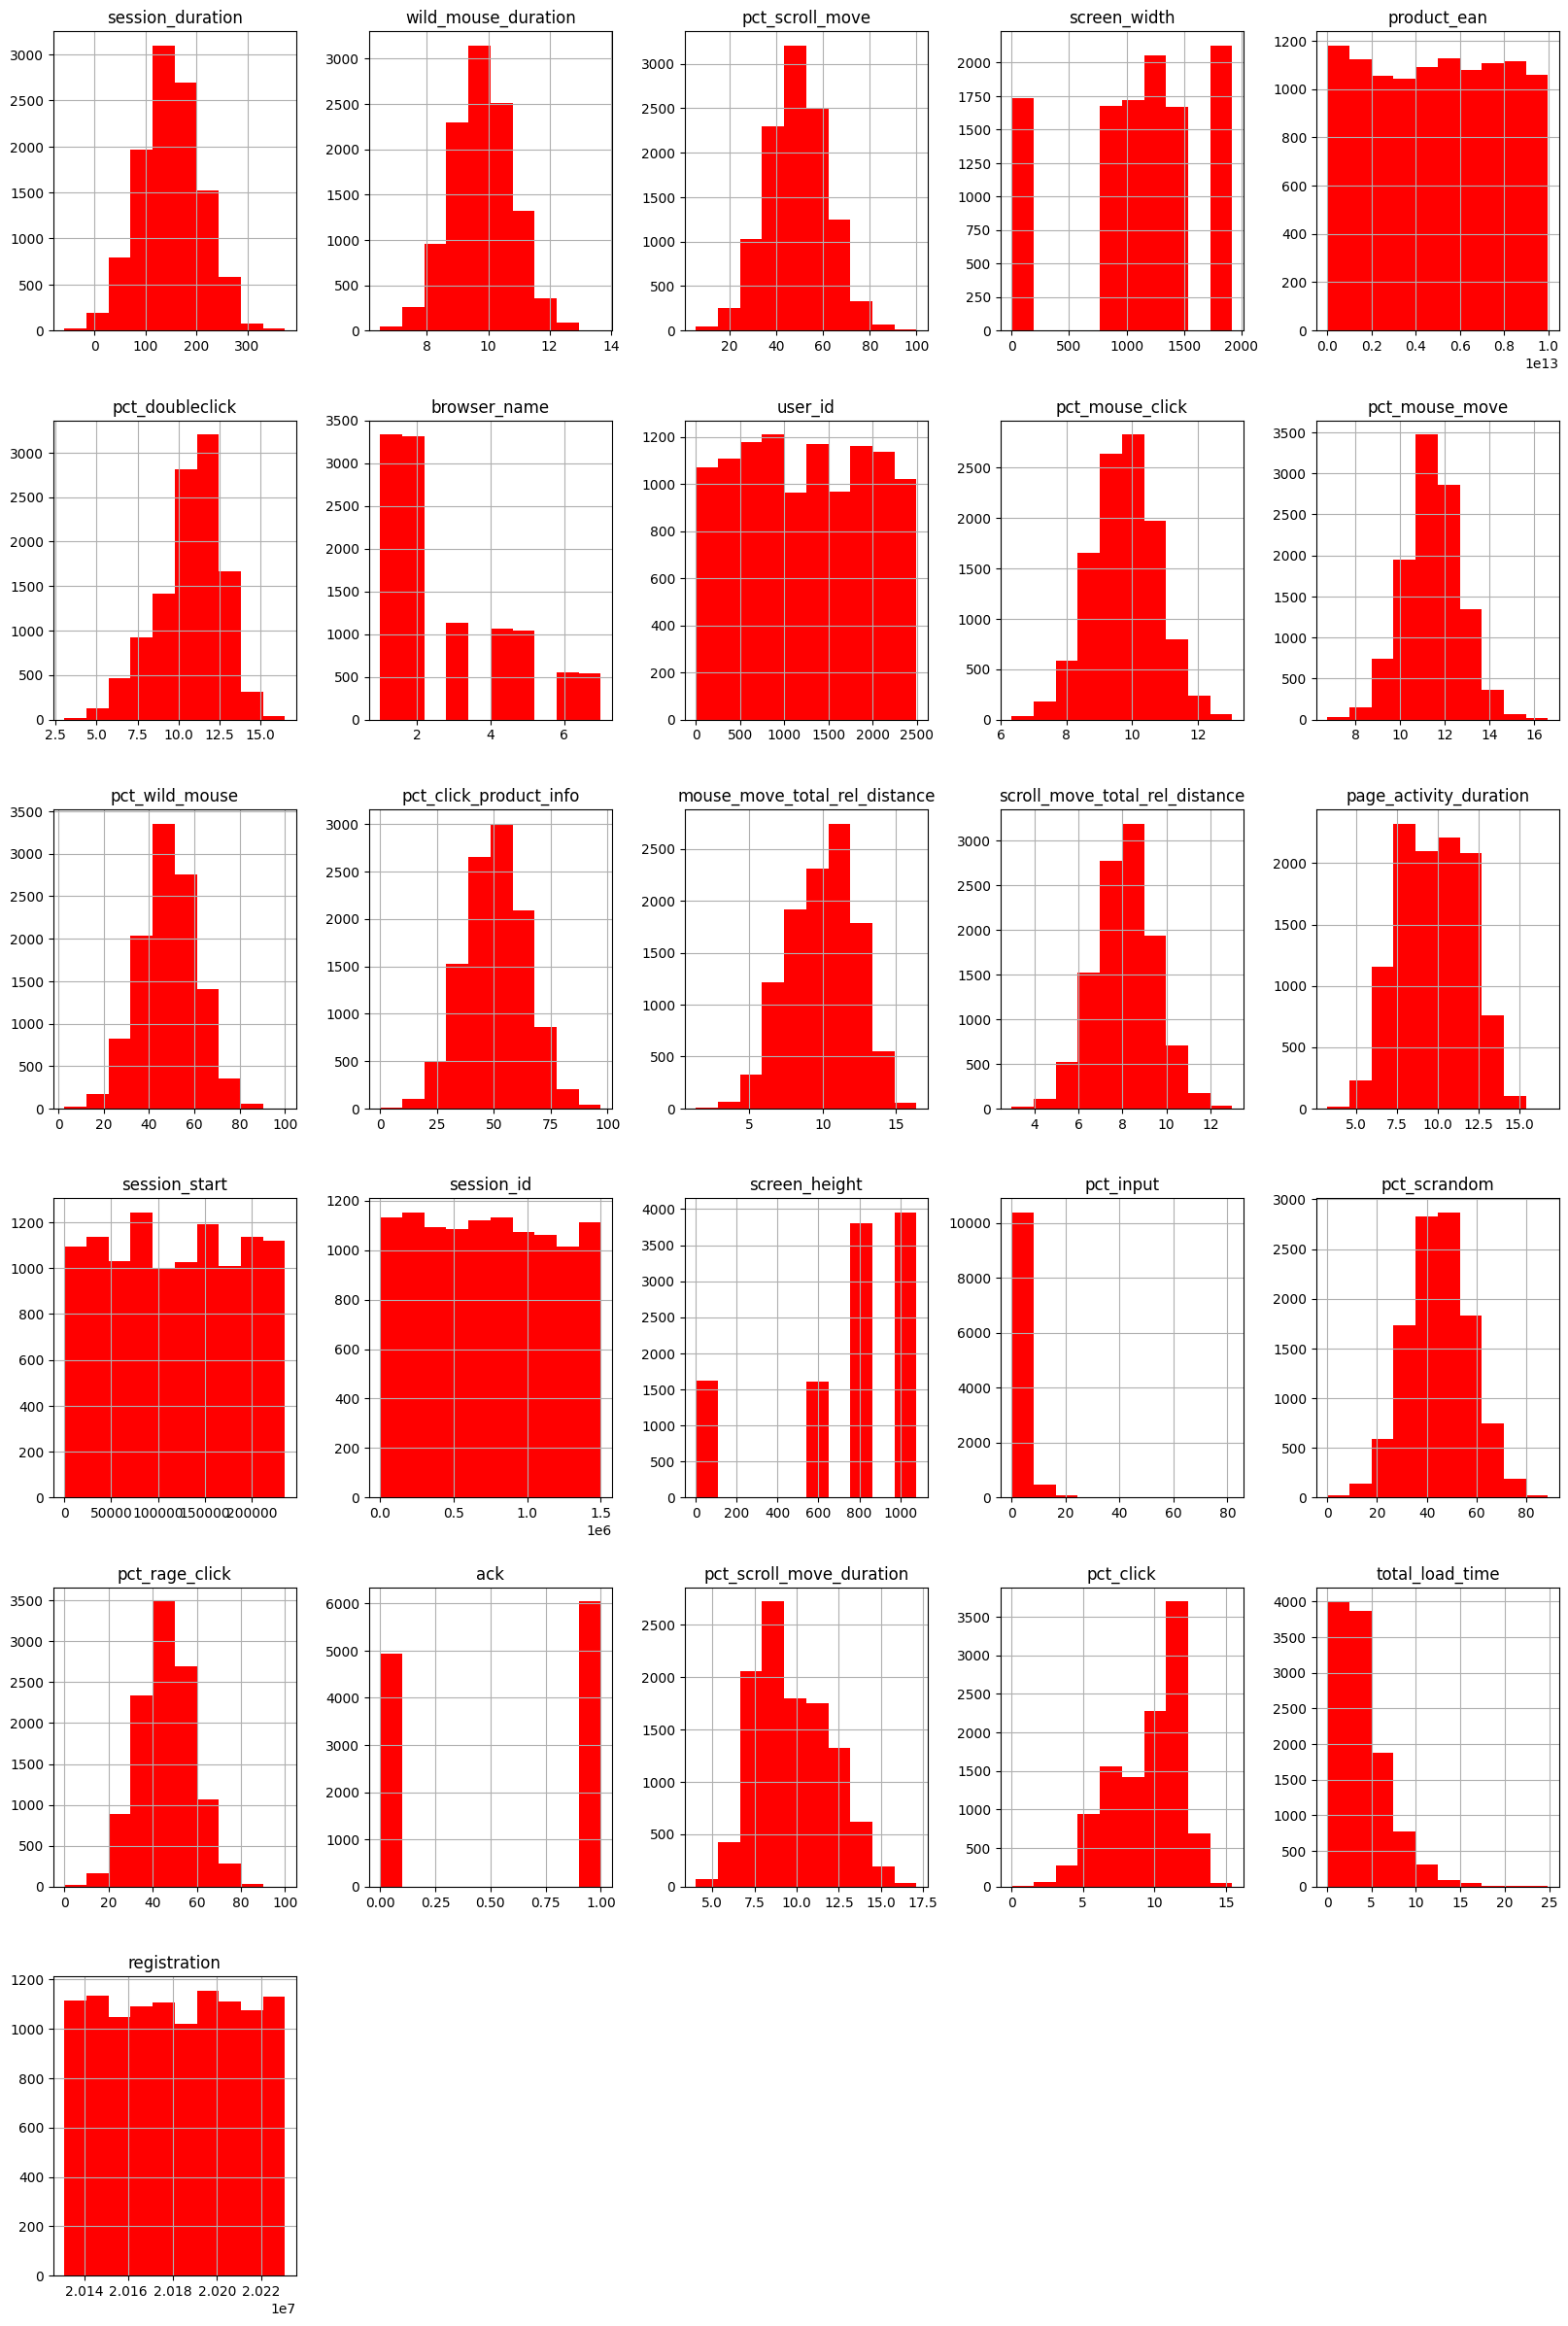

In [18]:
fig = plt.figure(figsize = (20,30))
ax = fig.gca()
merged_data.hist(ax = ax, color="red")

Vidíme, že máme vel'a vychýlených hodnôt, preto tento problém vyriešime spôsobom odstránenia vychýlených (odľahlých) pozorovaní (prvý spôsob) a nahradenia vychýlenej hodnoty hraničnými hodnotami rozdelenia (5% a 95%)

In [19]:
columns= ['session_duration','wild_mouse_duration','pct_scroll_move', 'product_ean', 'user_id','pct_mouse_click','pct_mouse_move','pct_wild_mouse', 'pct_click_product_info' ,'mouse_move_total_rel_distance', 'scroll_move_total_rel_distance','page_activity_duration','session_id','pct_input','pct_scrandom','pct_rage_click','ack','pct_scroll_move_duration','pct_click','total_load_time', 'screen_width', 'screen_height', 'session_start', 'browser_name', 'registration']
filtered_data_removed = merged_data.copy()
for column_name in columns:
    lower_limit = merged_data[column_name].quantile(0.05)
    upper_limit = merged_data[column_name].quantile(0.95)

    filtered_data_removed = filtered_data_removed[(filtered_data_removed[column_name] >= lower_limit) & (filtered_data_removed[column_name] <= upper_limit)]

C:\Users\patko\AppData\Local\Temp\ipykernel_21388\1752647060.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  filtered_data_removed.hist(ax = ax, color="red")


array([[<Axes: title={'center': 'session_duration'}>,
        <Axes: title={'center': 'wild_mouse_duration'}>,
        <Axes: title={'center': 'pct_scroll_move'}>,
        <Axes: title={'center': 'screen_width'}>,
        <Axes: title={'center': 'product_ean'}>],
       [<Axes: title={'center': 'pct_doubleclick'}>,
        <Axes: title={'center': 'browser_name'}>,
        <Axes: title={'center': 'user_id'}>,
        <Axes: title={'center': 'pct_mouse_click'}>,
        <Axes: title={'center': 'pct_mouse_move'}>],
       [<Axes: title={'center': 'pct_wild_mouse'}>,
        <Axes: title={'center': 'pct_click_product_info'}>,
        <Axes: title={'center': 'mouse_move_total_rel_distance'}>,
        <Axes: title={'center': 'scroll_move_total_rel_distance'}>,
        <Axes: title={'center': 'page_activity_duration'}>],
       [<Axes: title={'center': 'session_start'}>,
        <Axes: title={'center': 'session_id'}>,
        <Axes: title={'center': 'screen_height'}>,
        <Axes: title={'c

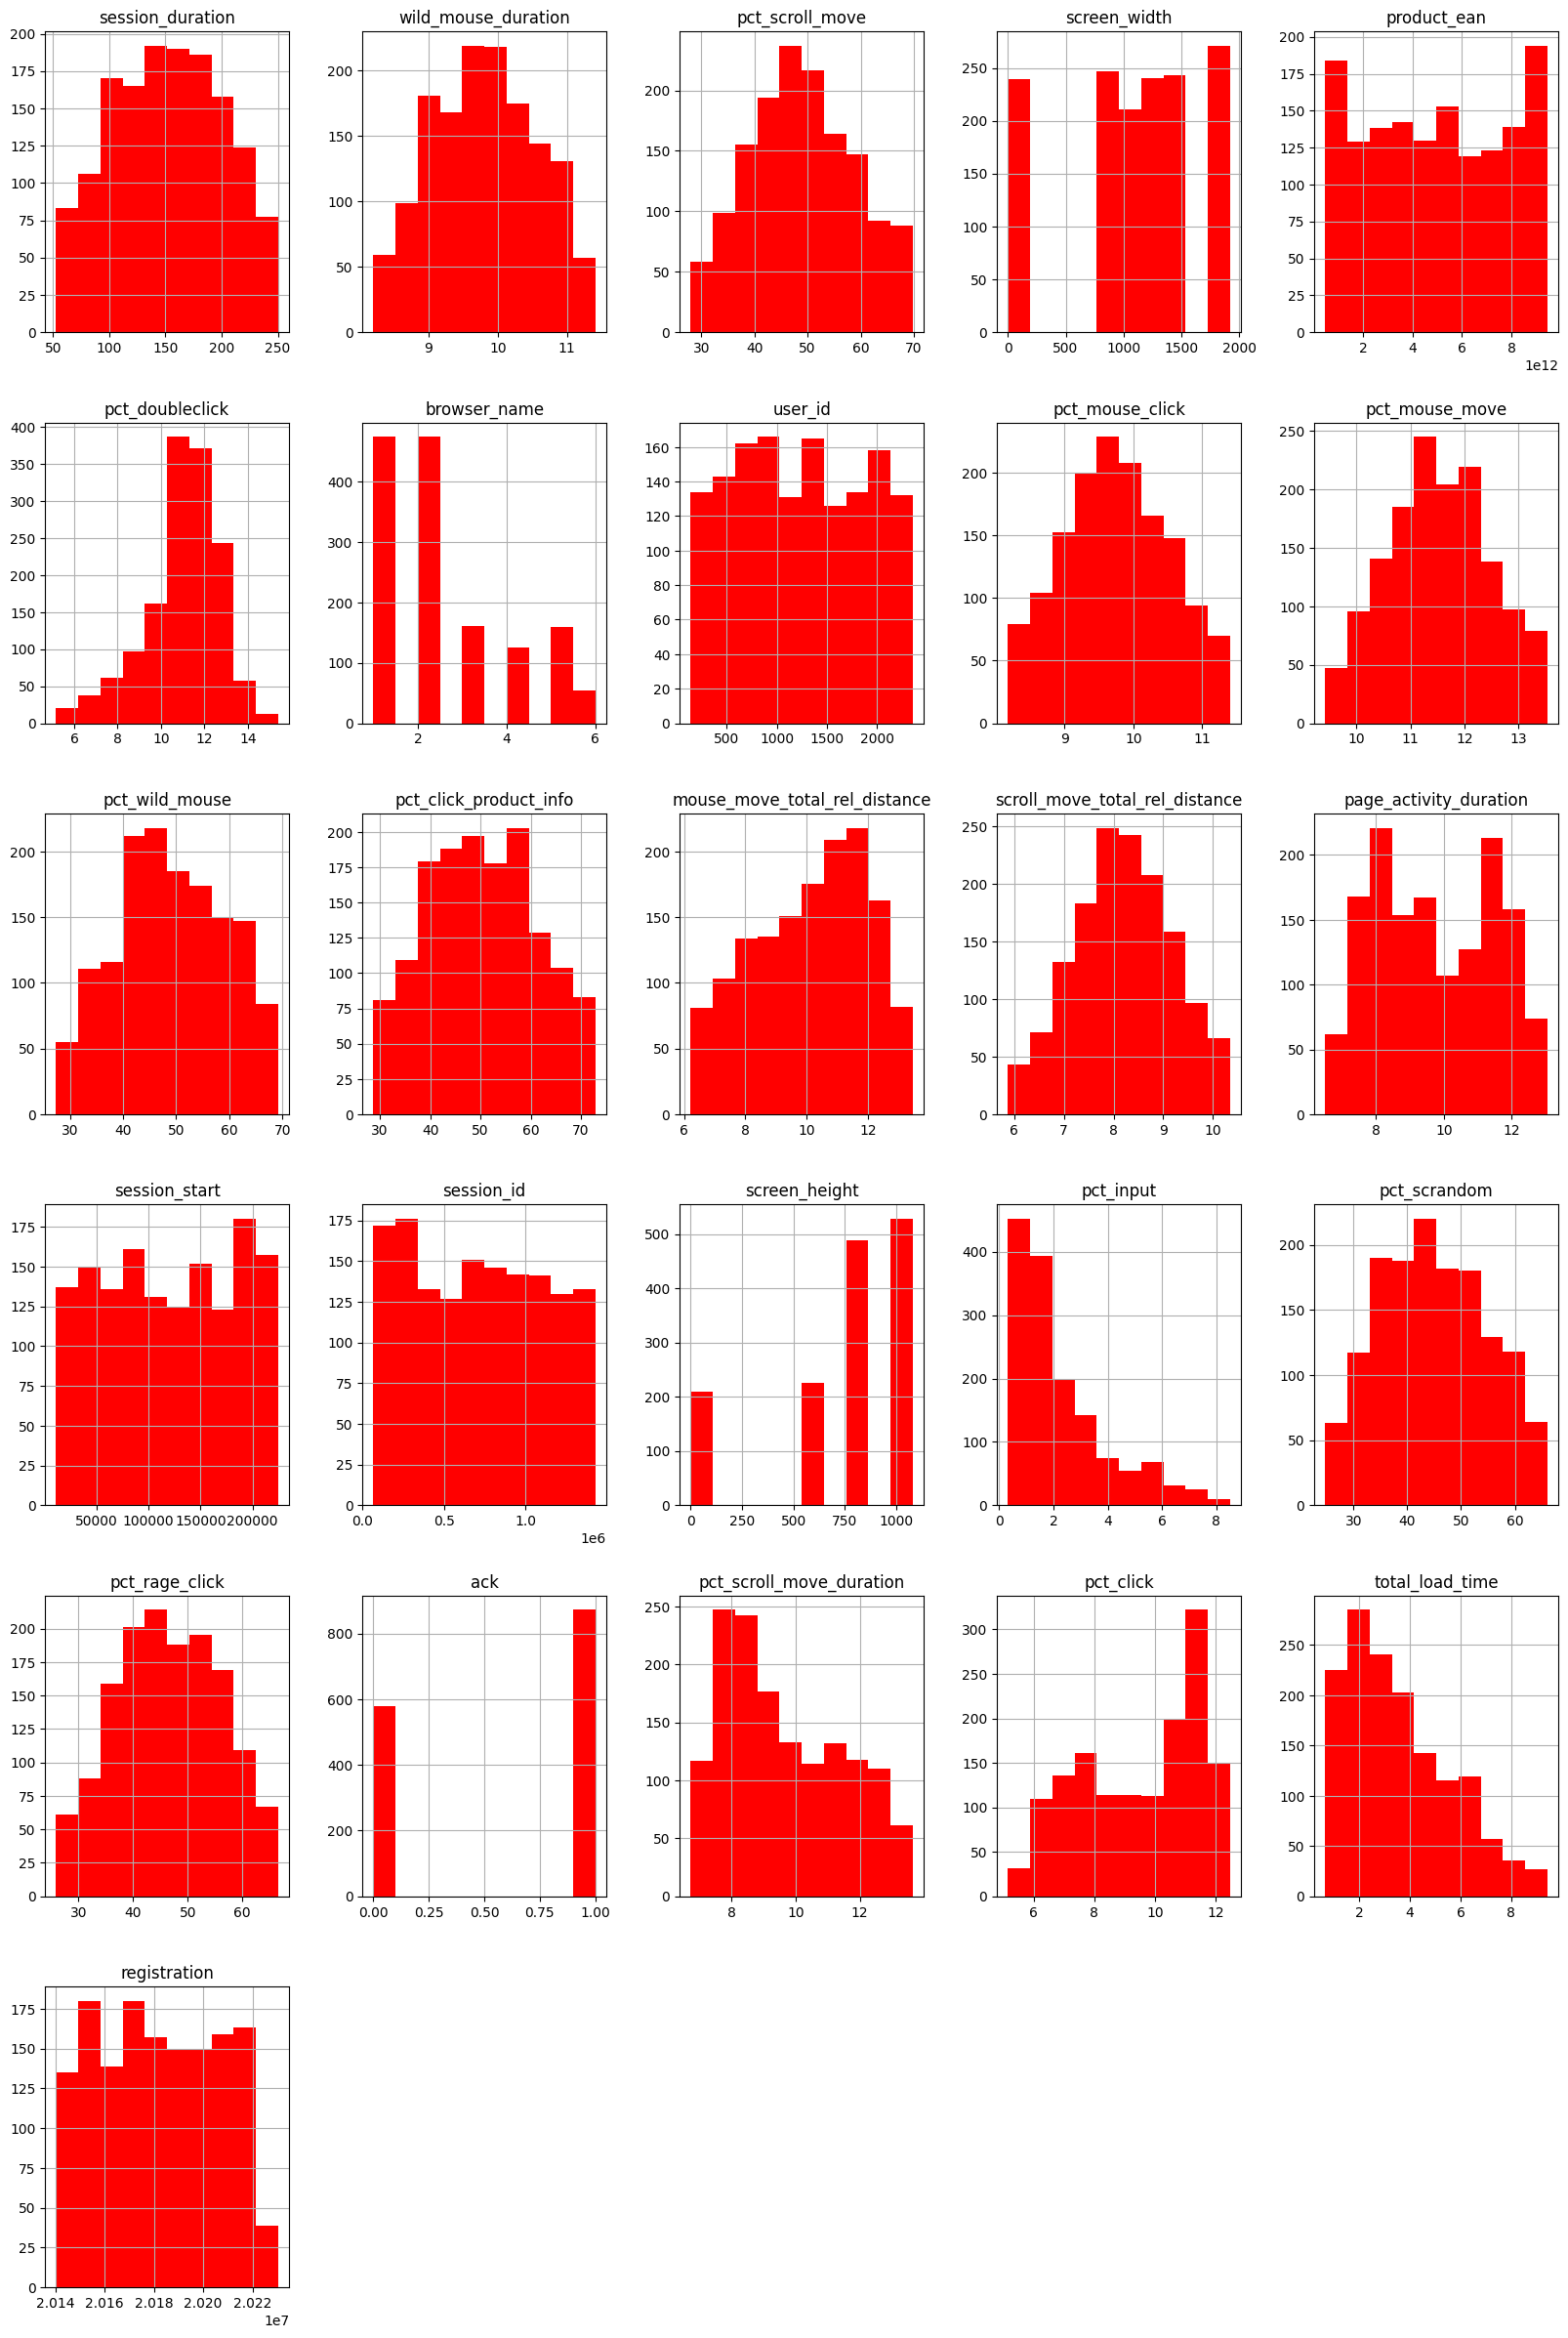

In [20]:
fig = plt.figure(figsize = (20,30))
ax = fig.gca()
filtered_data_removed.hist(ax = ax, color="red")

In [21]:
columns= ['session_duration','wild_mouse_duration','pct_scroll_move', 'product_ean', 'user_id','pct_mouse_click','pct_mouse_move','pct_wild_mouse', 'pct_click_product_info' ,'mouse_move_total_rel_distance', 'scroll_move_total_rel_distance','page_activity_duration','session_id','pct_input','pct_scrandom','pct_rage_click','ack','pct_scroll_move_duration','pct_click','total_load_time', 'browser_name', 'screen_width', 'screen_height', 'session_start', 'registration']
filtered_data_replaced = merged_data.copy()
for column_name in columns:
    lower_limit = merged_data[column_name].quantile(0.05)
    upper_limit = merged_data[column_name].quantile(0.95)
    
    filtered_data_replaced[column_name] = np.where(filtered_data_replaced[column_name] < lower_limit, lower_limit, filtered_data_replaced[column_name])
    filtered_data_replaced[column_name] = np.where(filtered_data_replaced[column_name] > upper_limit, upper_limit, filtered_data_replaced[column_name])

C:\Users\patko\AppData\Local\Temp\ipykernel_21388\2231625761.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  filtered_data_replaced.hist(ax = ax, color="red")


array([[<Axes: title={'center': 'session_duration'}>,
        <Axes: title={'center': 'wild_mouse_duration'}>,
        <Axes: title={'center': 'pct_scroll_move'}>,
        <Axes: title={'center': 'screen_width'}>,
        <Axes: title={'center': 'product_ean'}>],
       [<Axes: title={'center': 'pct_doubleclick'}>,
        <Axes: title={'center': 'browser_name'}>,
        <Axes: title={'center': 'user_id'}>,
        <Axes: title={'center': 'pct_mouse_click'}>,
        <Axes: title={'center': 'pct_mouse_move'}>],
       [<Axes: title={'center': 'pct_wild_mouse'}>,
        <Axes: title={'center': 'pct_click_product_info'}>,
        <Axes: title={'center': 'mouse_move_total_rel_distance'}>,
        <Axes: title={'center': 'scroll_move_total_rel_distance'}>,
        <Axes: title={'center': 'page_activity_duration'}>],
       [<Axes: title={'center': 'session_start'}>,
        <Axes: title={'center': 'session_id'}>,
        <Axes: title={'center': 'screen_height'}>,
        <Axes: title={'c

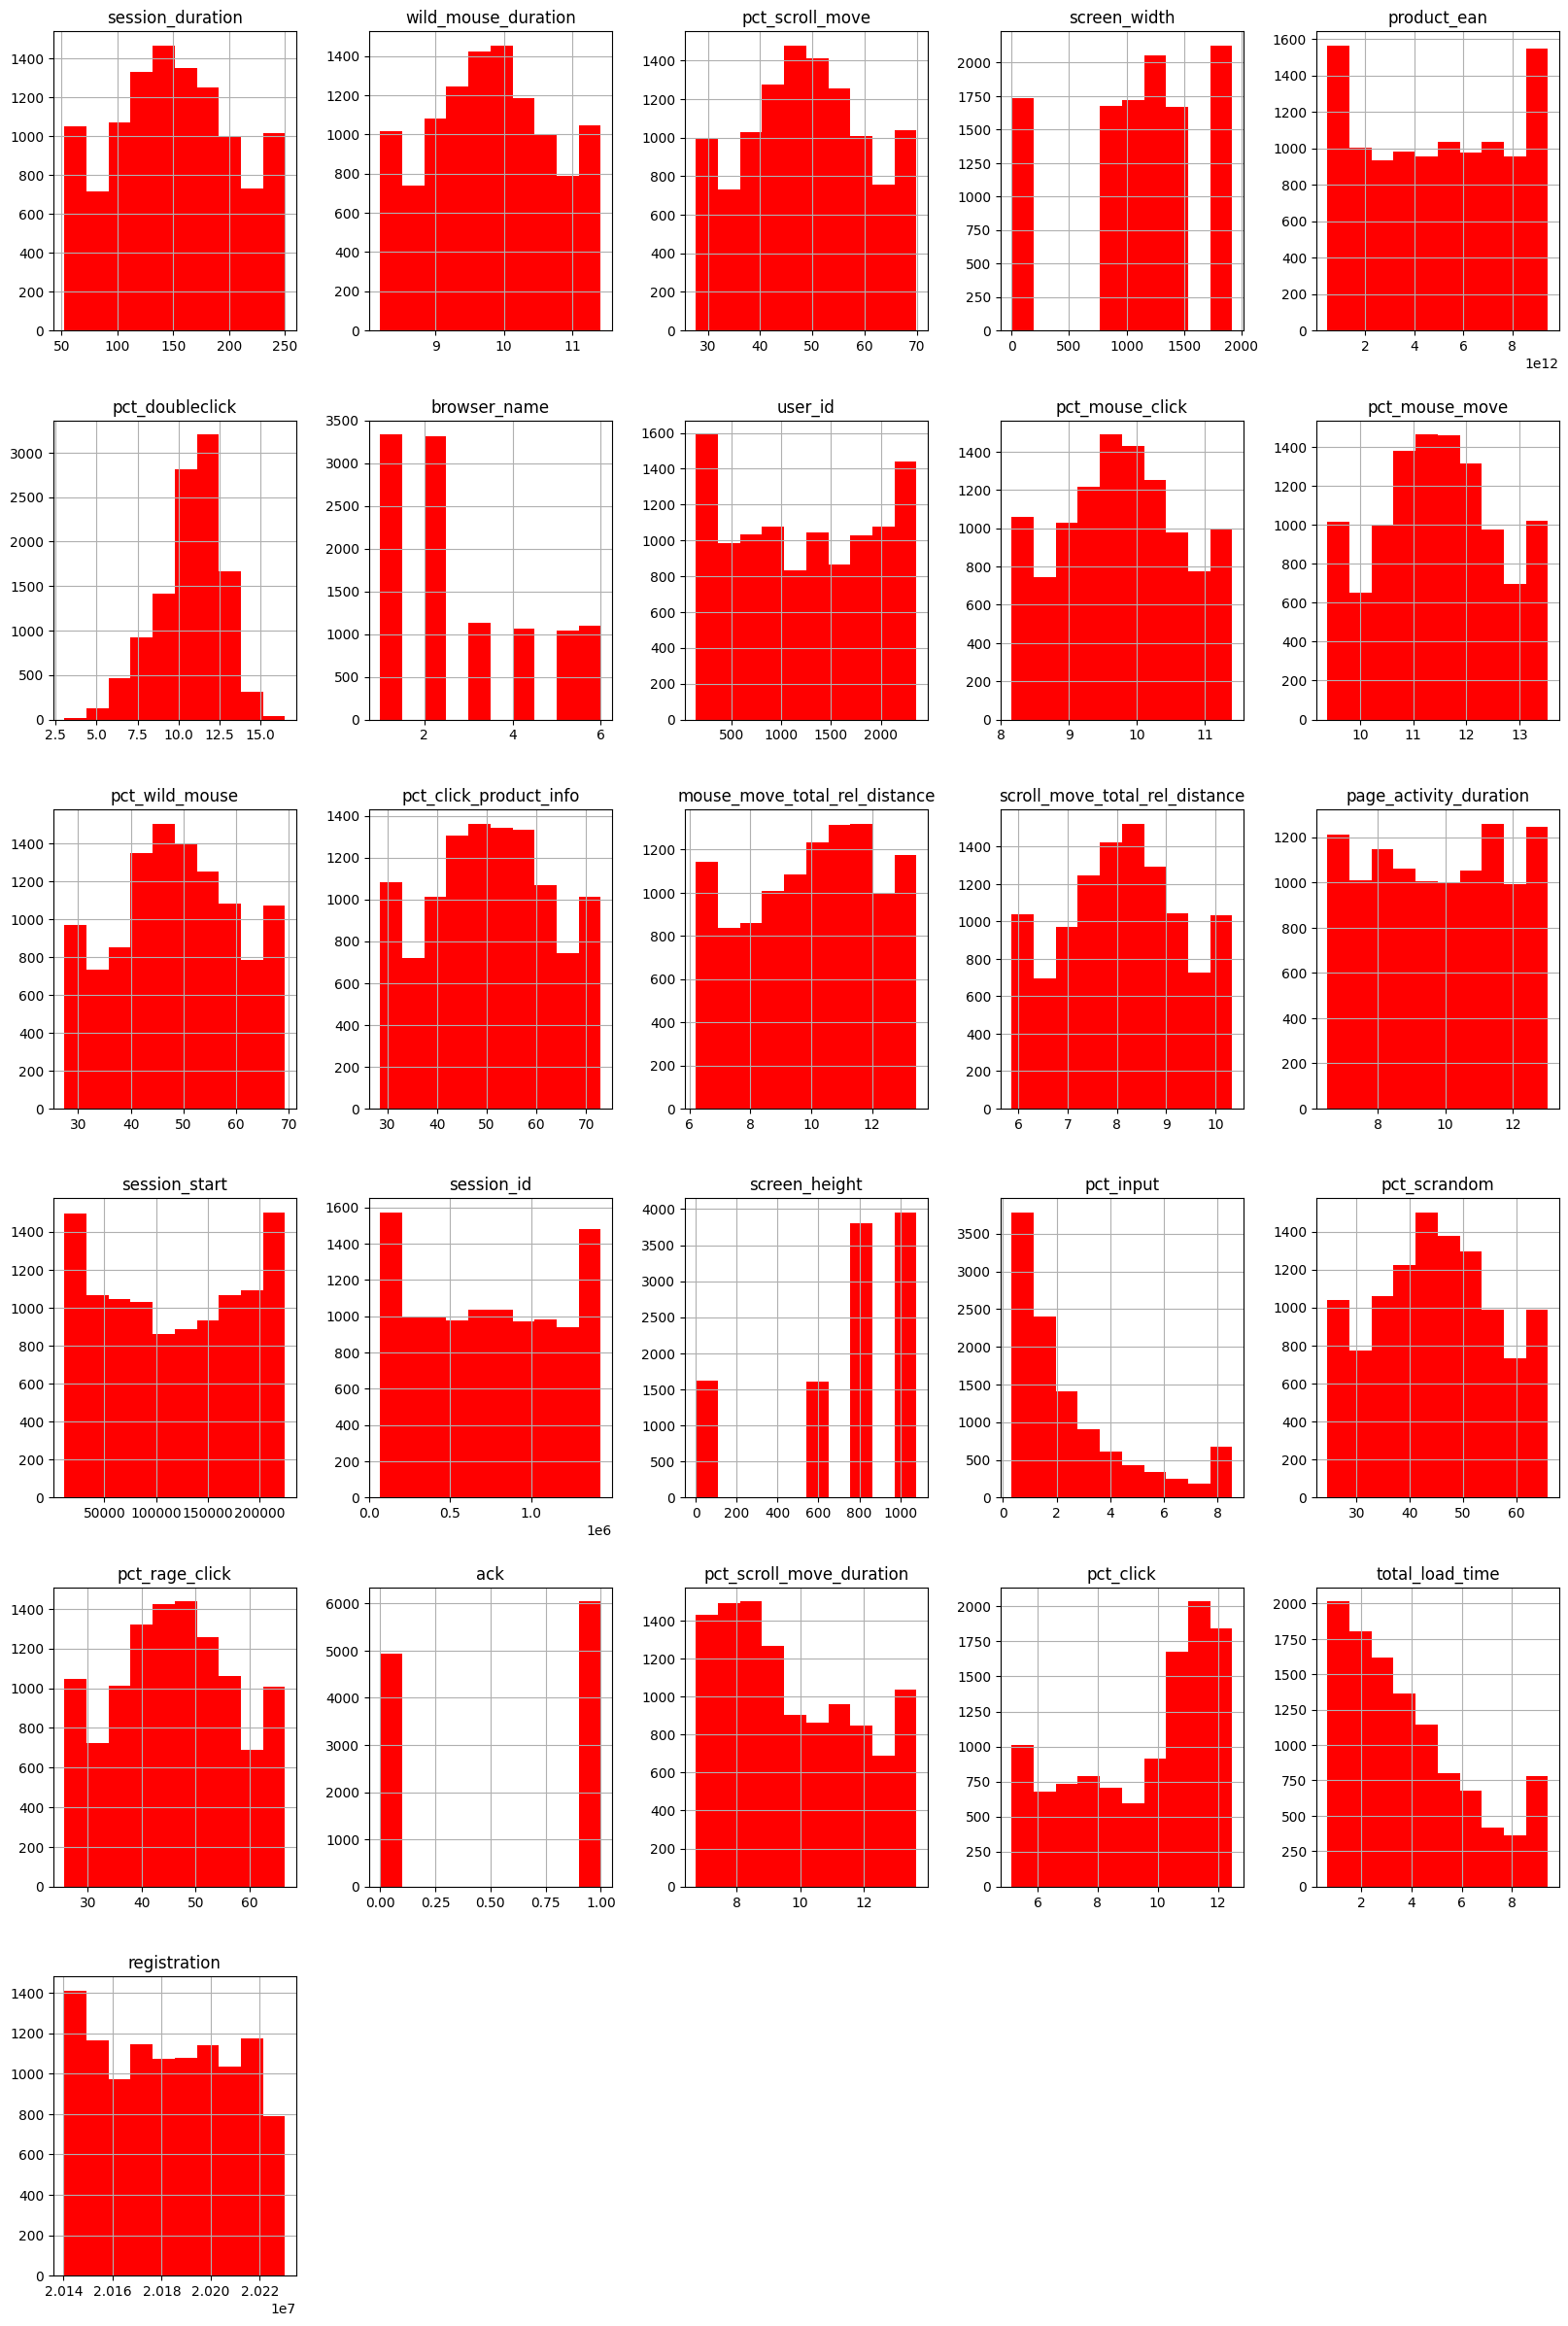

In [22]:
fig = plt.figure(figsize = (20,30))
ax = fig.gca()
filtered_data_replaced.hist(ax = ax, color="red")

# Realizácia predspracovania dát

Najprv skontrolujme, či sú všetky naše hodnoty numericke.

In [23]:
filtered_data_removed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1451 entries, 21 to 11053
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   session_duration                1451 non-null   float64
 1   wild_mouse_duration             1451 non-null   float64
 2   pct_scroll_move                 1451 non-null   float64
 3   screen_width                    1451 non-null   int32  
 4   product_ean                     1451 non-null   int64  
 5   pct_doubleclick                 1451 non-null   float64
 6   browser_name                    1451 non-null   int32  
 7   user_id                         1451 non-null   int64  
 8   pct_mouse_click                 1451 non-null   float64
 9   pct_mouse_move                  1451 non-null   float64
 10  pct_wild_mouse                  1451 non-null   float64
 11  pct_click_product_info          1451 non-null   float64
 12  mouse_move_total_rel_distance   1451 

Hodnoty stĺpcov username, name a mail sú jedinečné, takže pre nás nemá zmysel prepisovať ich hodnoty do číselného formátu. Rozhodli sme sa tieto tri stĺpce vymazať, aby sme s údajmi mohli ďalej pracovať. Potom sme sa session_id a user_id tiež rozhodli odstrániť, pretože aj toto sú jedinečné hodnoty a ich analýza nedáva zmysel.

In [24]:
filtered_data_removed.drop(['name','username','mail','user_id', 'session_id'], axis = 1, errors = 'ignore', inplace = True)

Rozhodli sme sa to rozdeliť na testovaciu a trénovaciu množinu tak, že 25% dát tvoria testovacie dáta a 75% trénovacie dáta. Budeme pokračovať len s trenovaciou datou.

In [75]:
len(filtered_data_removed)

1451

In [26]:
train_data, test_data = train_test_split(filtered_data_removed, test_size=0.25)
print('Trénovací dataset obsahuje:'+ str(len(train_data))+' záznamov\n'+'Testovacia vzorka obsahuje:'+  str(len(test_data))+' záznamov')

Trénovací dataset obsahuje:1088 záznamov
Testovacia vzorka obsahuje:363 záznamov


Rozdelili sme atribúty podľa distribúcie, pretože niektoré hodnoty sú z iného ako normálového rozdelenia podľa histogramov po odstránení outlierov.

In [27]:
first_group_analysis=['pct_doubleclick', 'pct_input', 'pct_click', 'total_load_time', 'pct_mouse_move', 'registration']

C:\Users\patko\AppData\Local\Temp\ipykernel_21388\3510199793.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  train_data[first_group_analysis].hist(ax = ax)


array([[<Axes: title={'center': 'pct_doubleclick'}>,
        <Axes: title={'center': 'pct_input'}>],
       [<Axes: title={'center': 'pct_click'}>,
        <Axes: title={'center': 'total_load_time'}>],
       [<Axes: title={'center': 'pct_mouse_move'}>,
        <Axes: title={'center': 'registration'}>]], dtype=object)

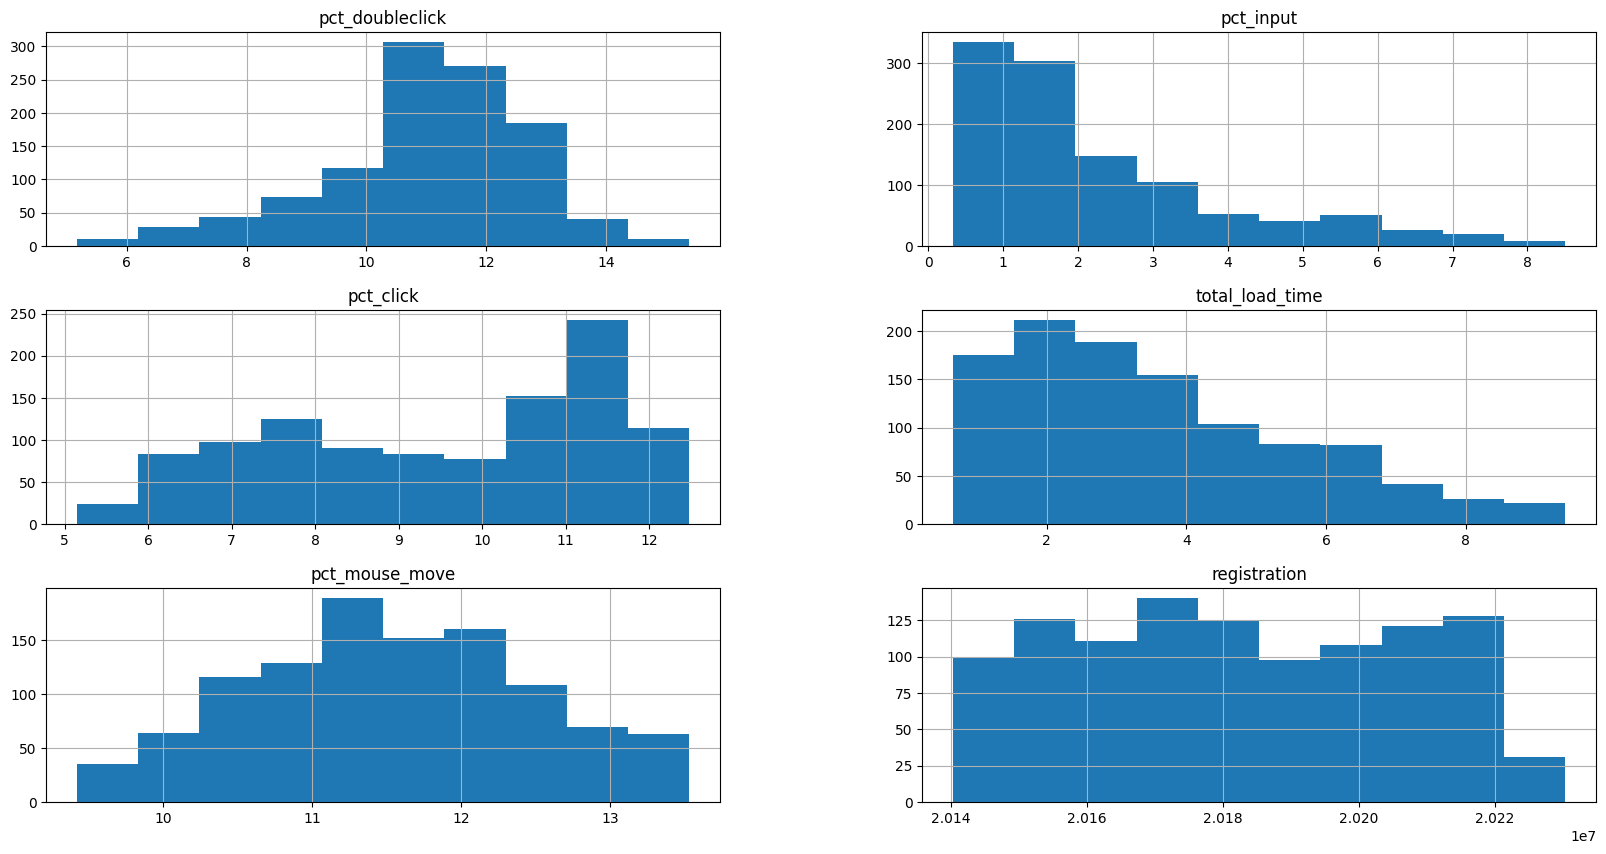

In [28]:
fig = plt.figure(figsize = (20,10))
ax = fig.gca()
train_data[first_group_analysis].hist(ax = ax)

Rozhodli sme aplikovať quantile transformer na prvú skupinu(first_group_a), aby sme mali normálnu distribuciu.

C:\Users\patko\AppData\Local\Temp\ipykernel_21388\2249362545.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  train_data[first_group_analysis].hist(ax = ax)


array([[<Axes: title={'center': 'pct_doubleclick'}>,
        <Axes: title={'center': 'pct_input'}>],
       [<Axes: title={'center': 'pct_click'}>,
        <Axes: title={'center': 'total_load_time'}>],
       [<Axes: title={'center': 'pct_mouse_move'}>,
        <Axes: title={'center': 'registration'}>]], dtype=object)

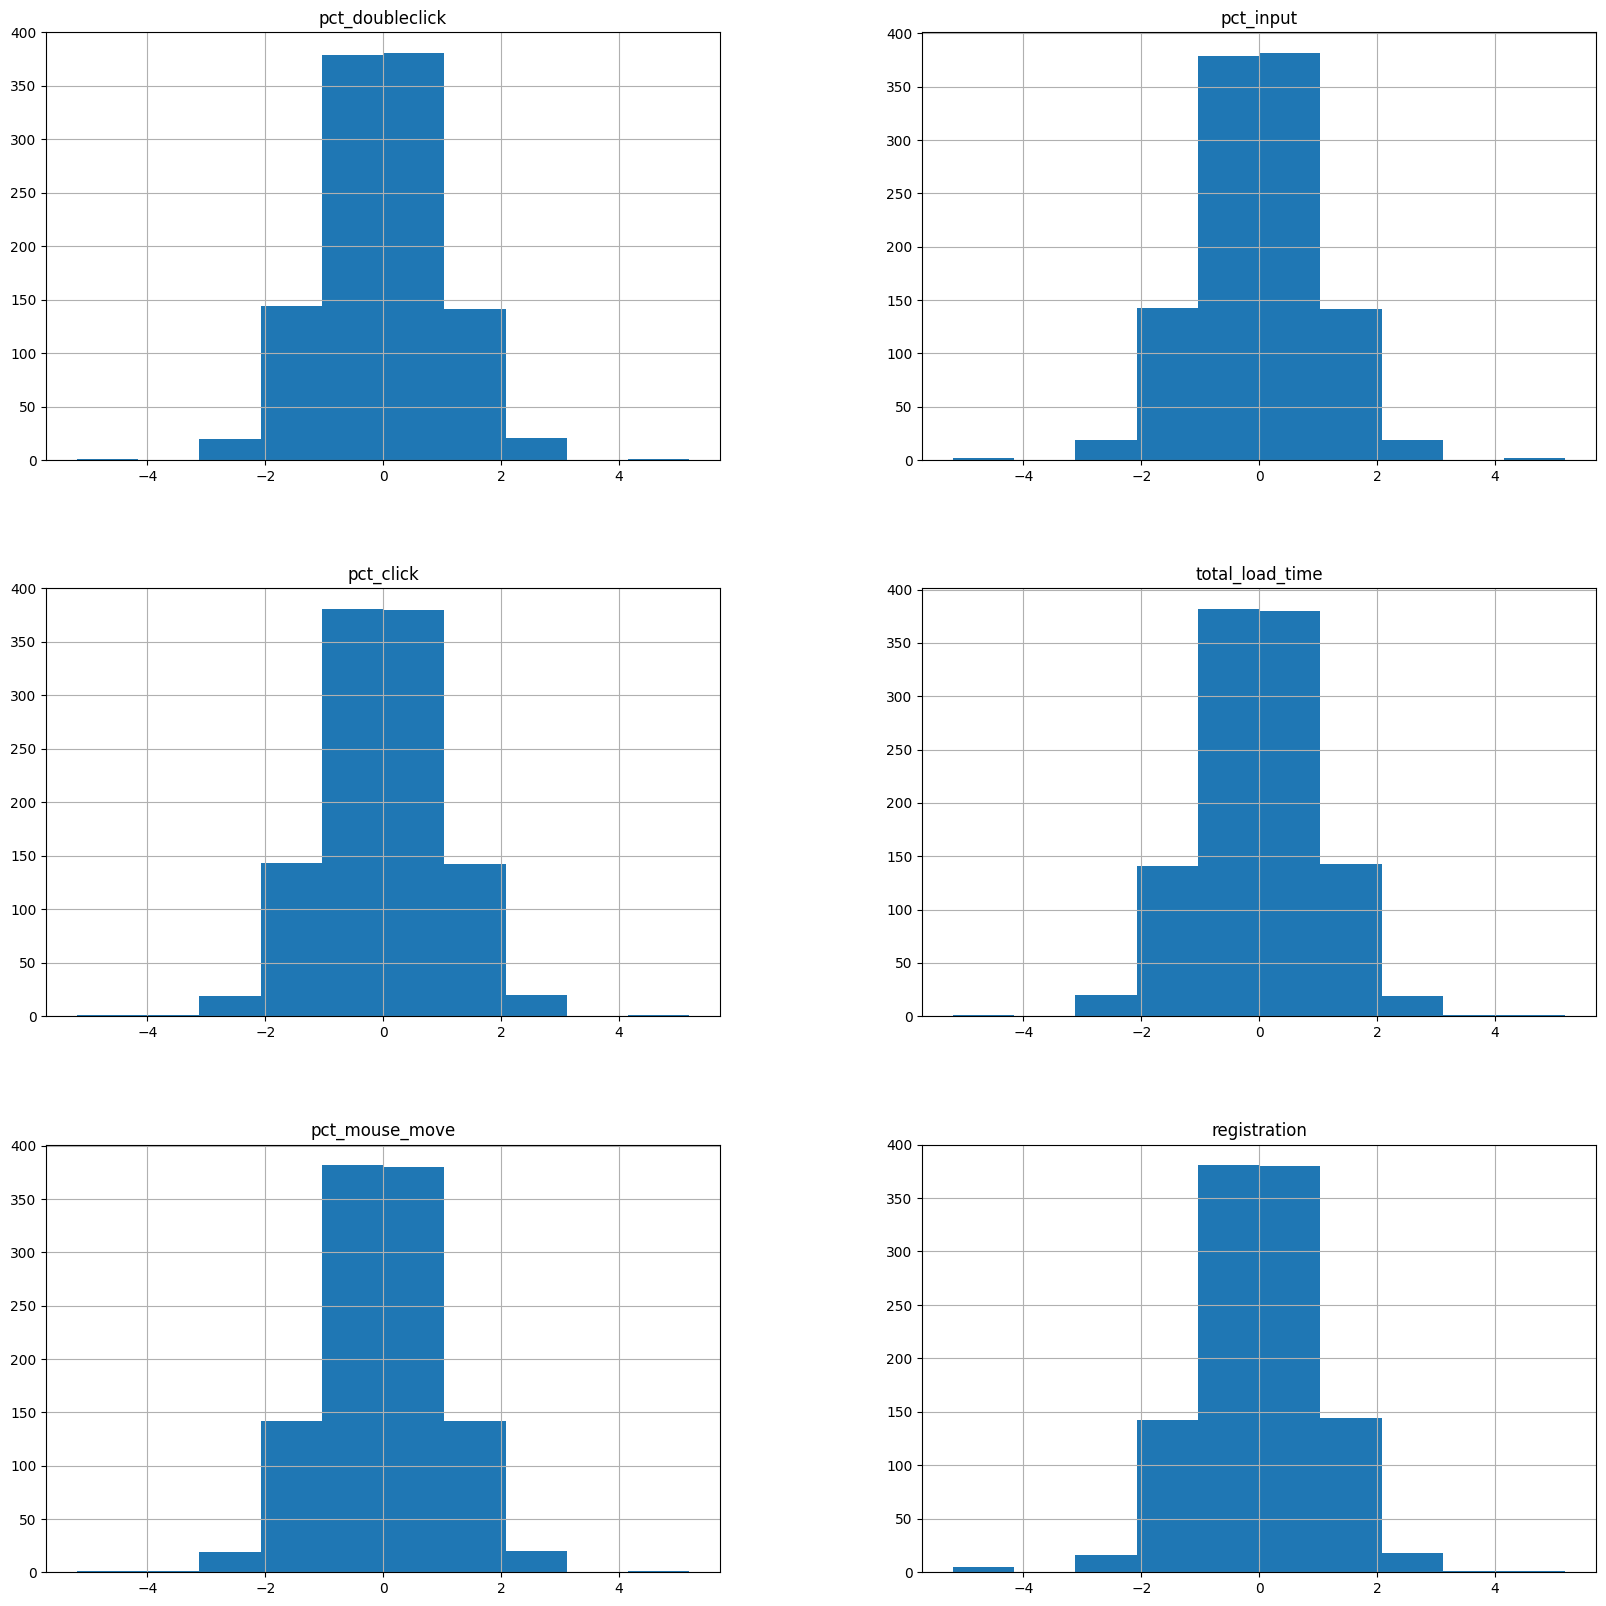

In [29]:
qt = QuantileTransformer(output_distribution="normal",n_quantiles=1000)
train_data[first_group_analysis] = qt.fit_transform(train_data[first_group_analysis])
fig = plt.figure(figsize = (20,20))
ax = fig.gca()
train_data[first_group_analysis].hist(ax = ax)

Pre druhú skupinu(second_group_analysis) sme použili power transformation s metódou Yeo-Johnson na symetrické rozdelenie hodnôt.

In [30]:
second_group_analysis=['session_duration', 'mouse_move_total_rel_distance', 'scroll_move_total_rel_distance','pct_rage_click','pct_scroll_move_duration']

C:\Users\patko\AppData\Local\Temp\ipykernel_21388\2637543501.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  train_data[second_group_analysis].hist(ax = ax)


array([[<Axes: title={'center': 'session_duration'}>,
        <Axes: title={'center': 'mouse_move_total_rel_distance'}>],
       [<Axes: title={'center': 'scroll_move_total_rel_distance'}>,
        <Axes: title={'center': 'pct_rage_click'}>],
       [<Axes: title={'center': 'pct_scroll_move_duration'}>, <Axes: >]],
      dtype=object)

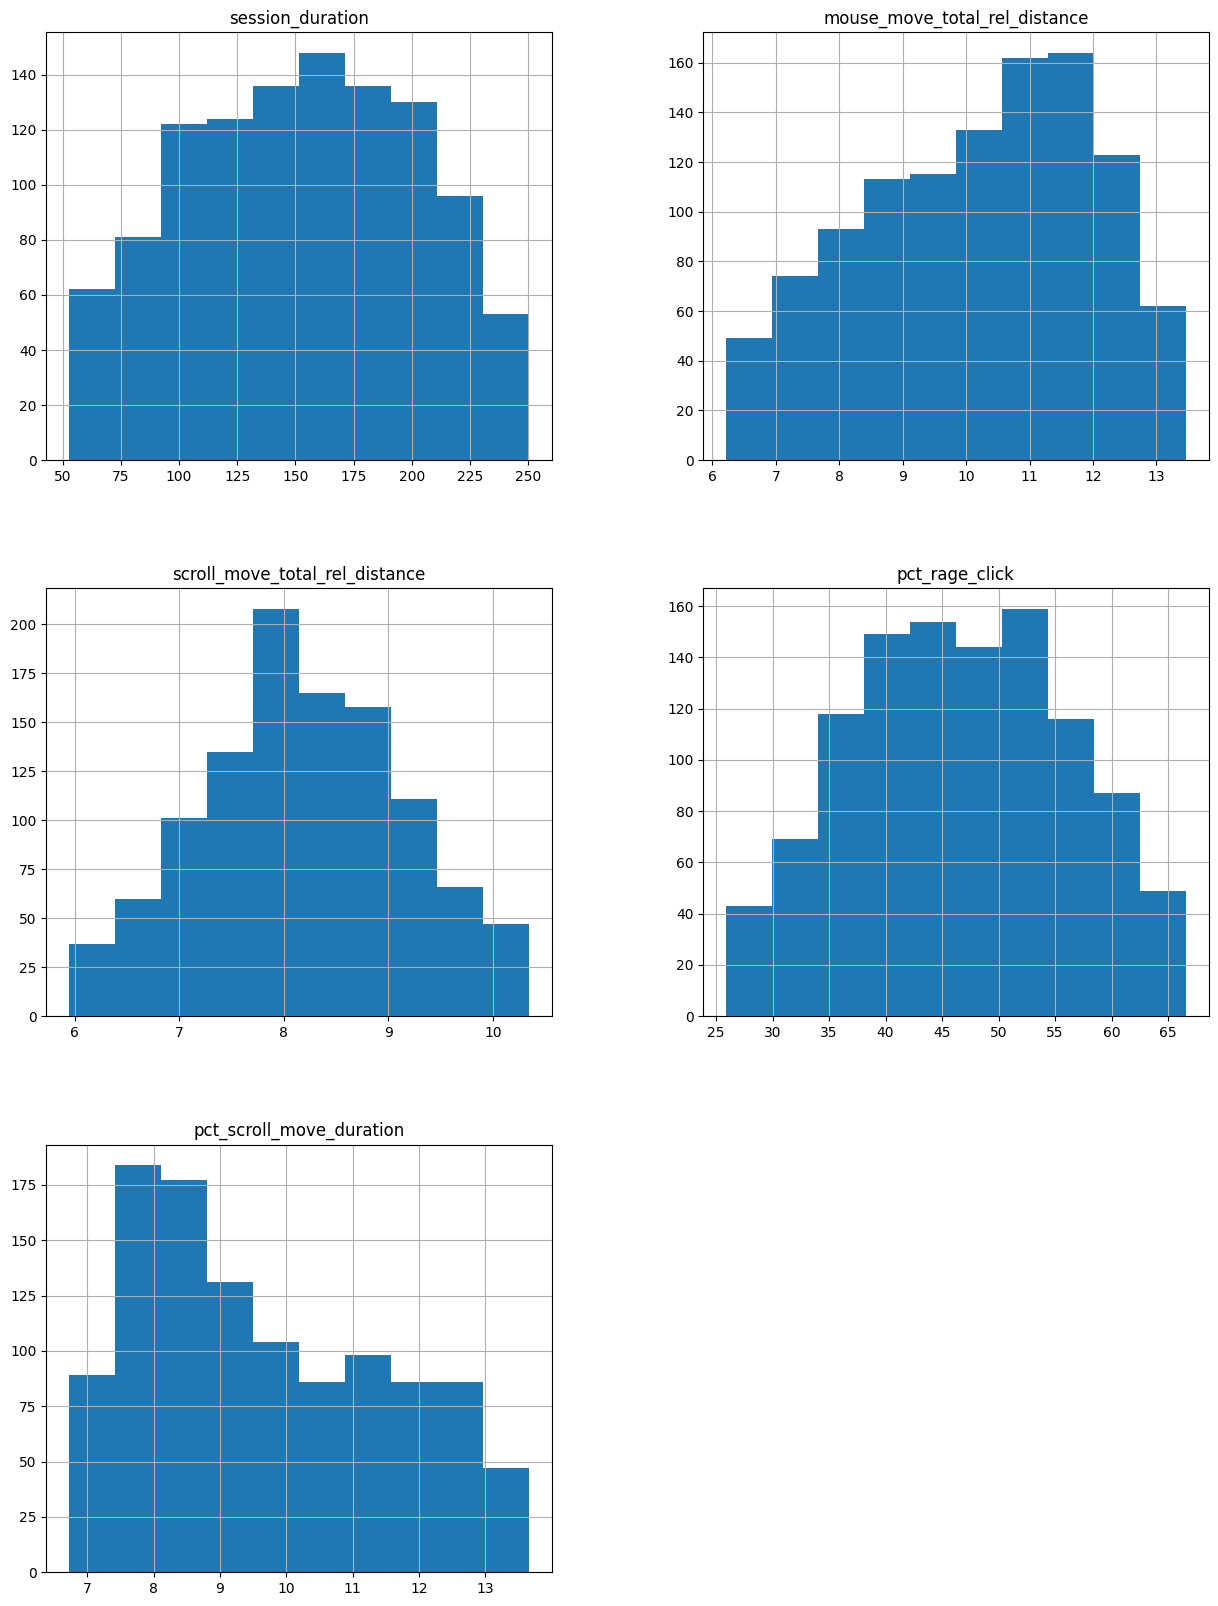

In [31]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
train_data[second_group_analysis].hist(ax = ax)

C:\Users\patko\AppData\Local\Temp\ipykernel_21388\3304267294.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  train_data[second_group_analysis].hist(ax = ax)


array([[<Axes: title={'center': 'session_duration'}>,
        <Axes: title={'center': 'mouse_move_total_rel_distance'}>],
       [<Axes: title={'center': 'scroll_move_total_rel_distance'}>,
        <Axes: title={'center': 'pct_rage_click'}>],
       [<Axes: title={'center': 'pct_scroll_move_duration'}>, <Axes: >]],
      dtype=object)

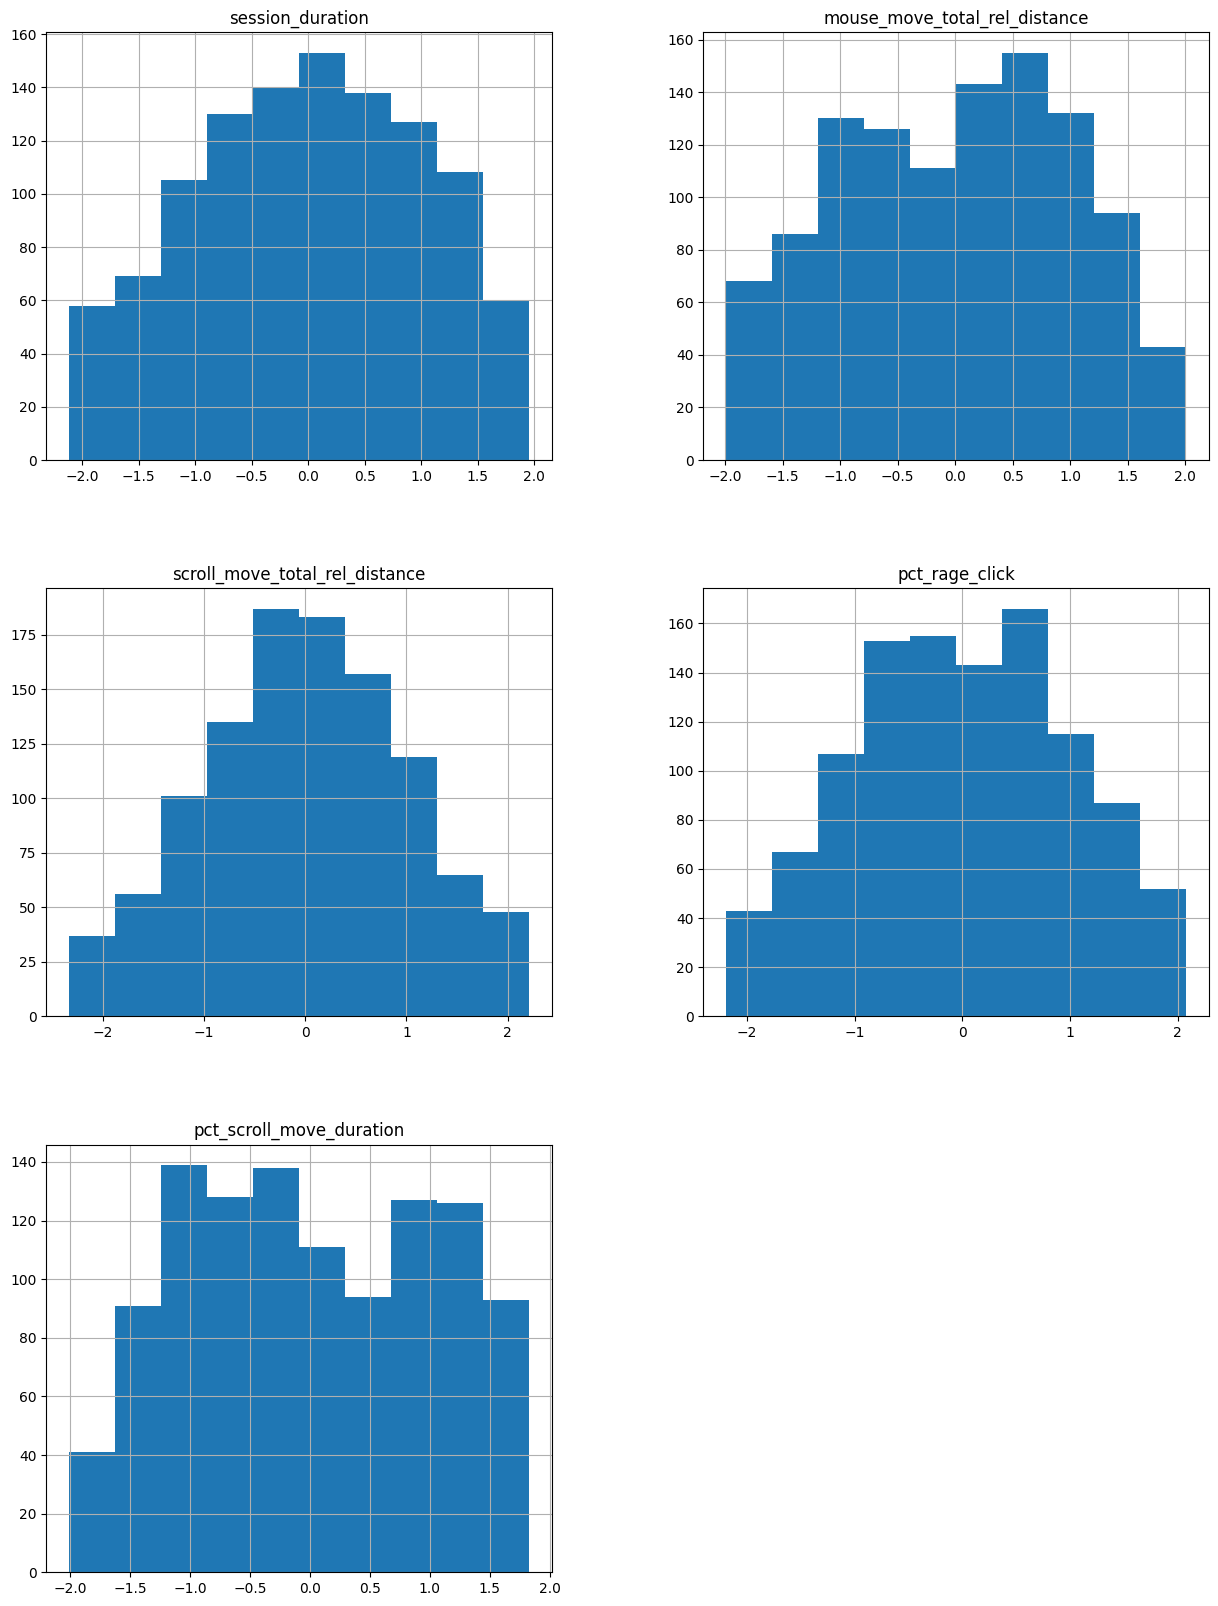

In [32]:
power = PowerTransformer(method='yeo-johnson', standardize=True) 
train_data[second_group_analysis] = power.fit_transform(train_data[second_group_analysis])
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
train_data[second_group_analysis].hist(ax = ax)

In [33]:
third_group_analysis=['product_ean', 'session_start', 'page_activity_duration','mouse_move_total_rel_distance', 'pct_scroll_move_duration']

C:\Users\patko\AppData\Local\Temp\ipykernel_21388\211916601.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  train_data[third_group_analysis].hist(ax = ax)


array([[<Axes: title={'center': 'product_ean'}>,
        <Axes: title={'center': 'session_start'}>],
       [<Axes: title={'center': 'page_activity_duration'}>,
        <Axes: title={'center': 'mouse_move_total_rel_distance'}>],
       [<Axes: title={'center': 'pct_scroll_move_duration'}>, <Axes: >]],
      dtype=object)

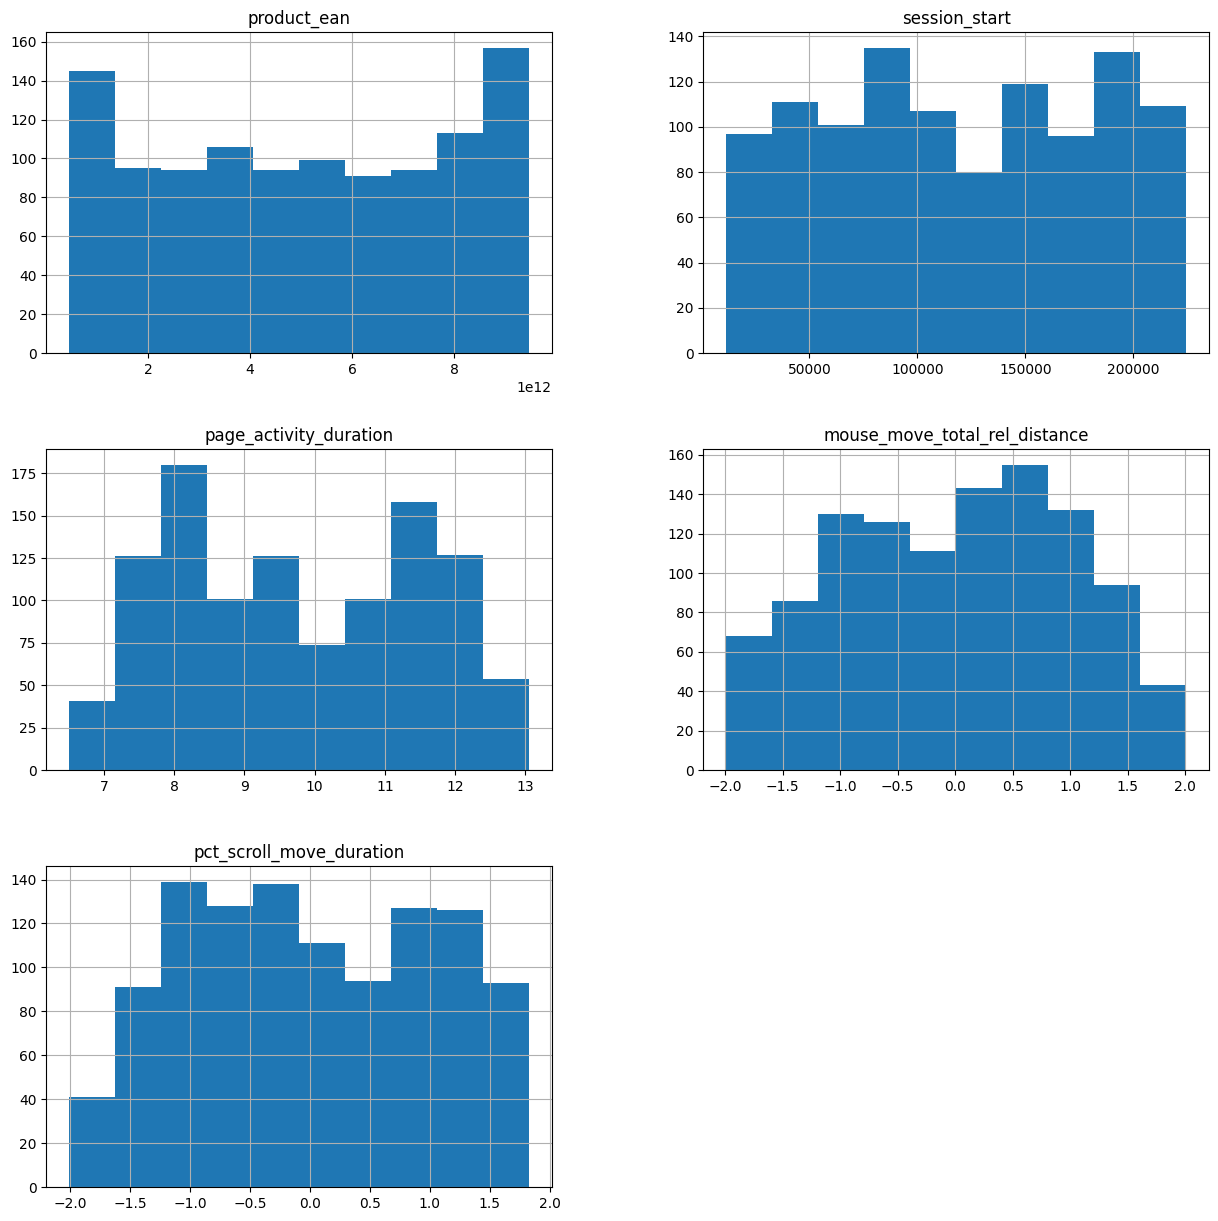

In [34]:
fig = plt.figure(figsize = (15,15))
ax = fig.gca()
train_data[third_group_analysis].hist(ax = ax)

Pre tretiu skupinu sme použili kombináciu MixMin transformer a quantile transformer, aby sme približili sa ku normálnej distribucii.

C:\Users\patko\AppData\Local\Temp\ipykernel_21388\2264404447.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  train_data[third_group_analysis].hist(ax = ax)


array([[<Axes: title={'center': 'product_ean'}>,
        <Axes: title={'center': 'session_start'}>],
       [<Axes: title={'center': 'page_activity_duration'}>,
        <Axes: title={'center': 'mouse_move_total_rel_distance'}>],
       [<Axes: title={'center': 'pct_scroll_move_duration'}>, <Axes: >]],
      dtype=object)

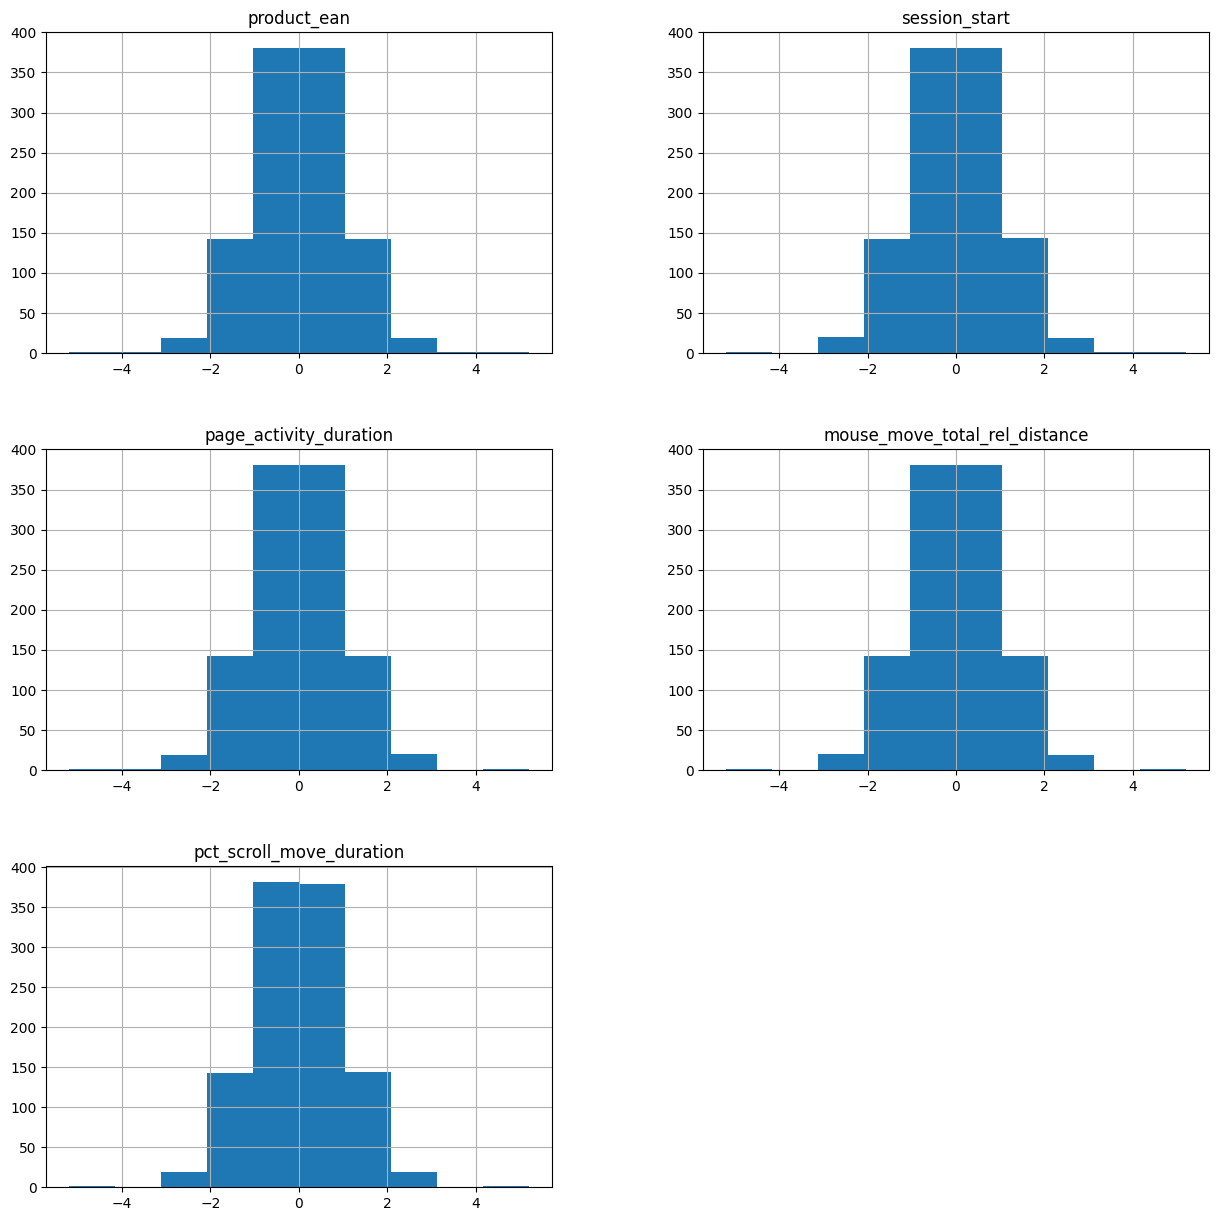

In [35]:
scaler = MinMaxScaler()
train_data[third_group_analysis] = scaler.fit_transform(train_data[third_group_analysis])
train_data[third_group_analysis] = qt.fit_transform(train_data[third_group_analysis])
fig = plt.figure(figsize = (15,15))
ax = fig.gca()
train_data[third_group_analysis].hist(ax = ax)

Potom pre normalizovanie atribútov použili sme standard scaler na všetky kategorické atribúty.

In [36]:
standard_scaler = StandardScaler()
train_data[second_group_analysis] = standard_scaler.fit_transform(train_data[second_group_analysis])

C:\Users\patko\AppData\Local\Temp\ipykernel_21388\2748110766.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  train_data.hist(ax = ax)


array([[<Axes: title={'center': 'session_duration'}>,
        <Axes: title={'center': 'wild_mouse_duration'}>,
        <Axes: title={'center': 'pct_scroll_move'}>,
        <Axes: title={'center': 'screen_width'}>,
        <Axes: title={'center': 'product_ean'}>],
       [<Axes: title={'center': 'pct_doubleclick'}>,
        <Axes: title={'center': 'browser_name'}>,
        <Axes: title={'center': 'pct_mouse_click'}>,
        <Axes: title={'center': 'pct_mouse_move'}>,
        <Axes: title={'center': 'pct_wild_mouse'}>],
       [<Axes: title={'center': 'pct_click_product_info'}>,
        <Axes: title={'center': 'mouse_move_total_rel_distance'}>,
        <Axes: title={'center': 'scroll_move_total_rel_distance'}>,
        <Axes: title={'center': 'page_activity_duration'}>,
        <Axes: title={'center': 'session_start'}>],
       [<Axes: title={'center': 'screen_height'}>,
        <Axes: title={'center': 'pct_input'}>,
        <Axes: title={'center': 'pct_scrandom'}>,
        <Axes: title

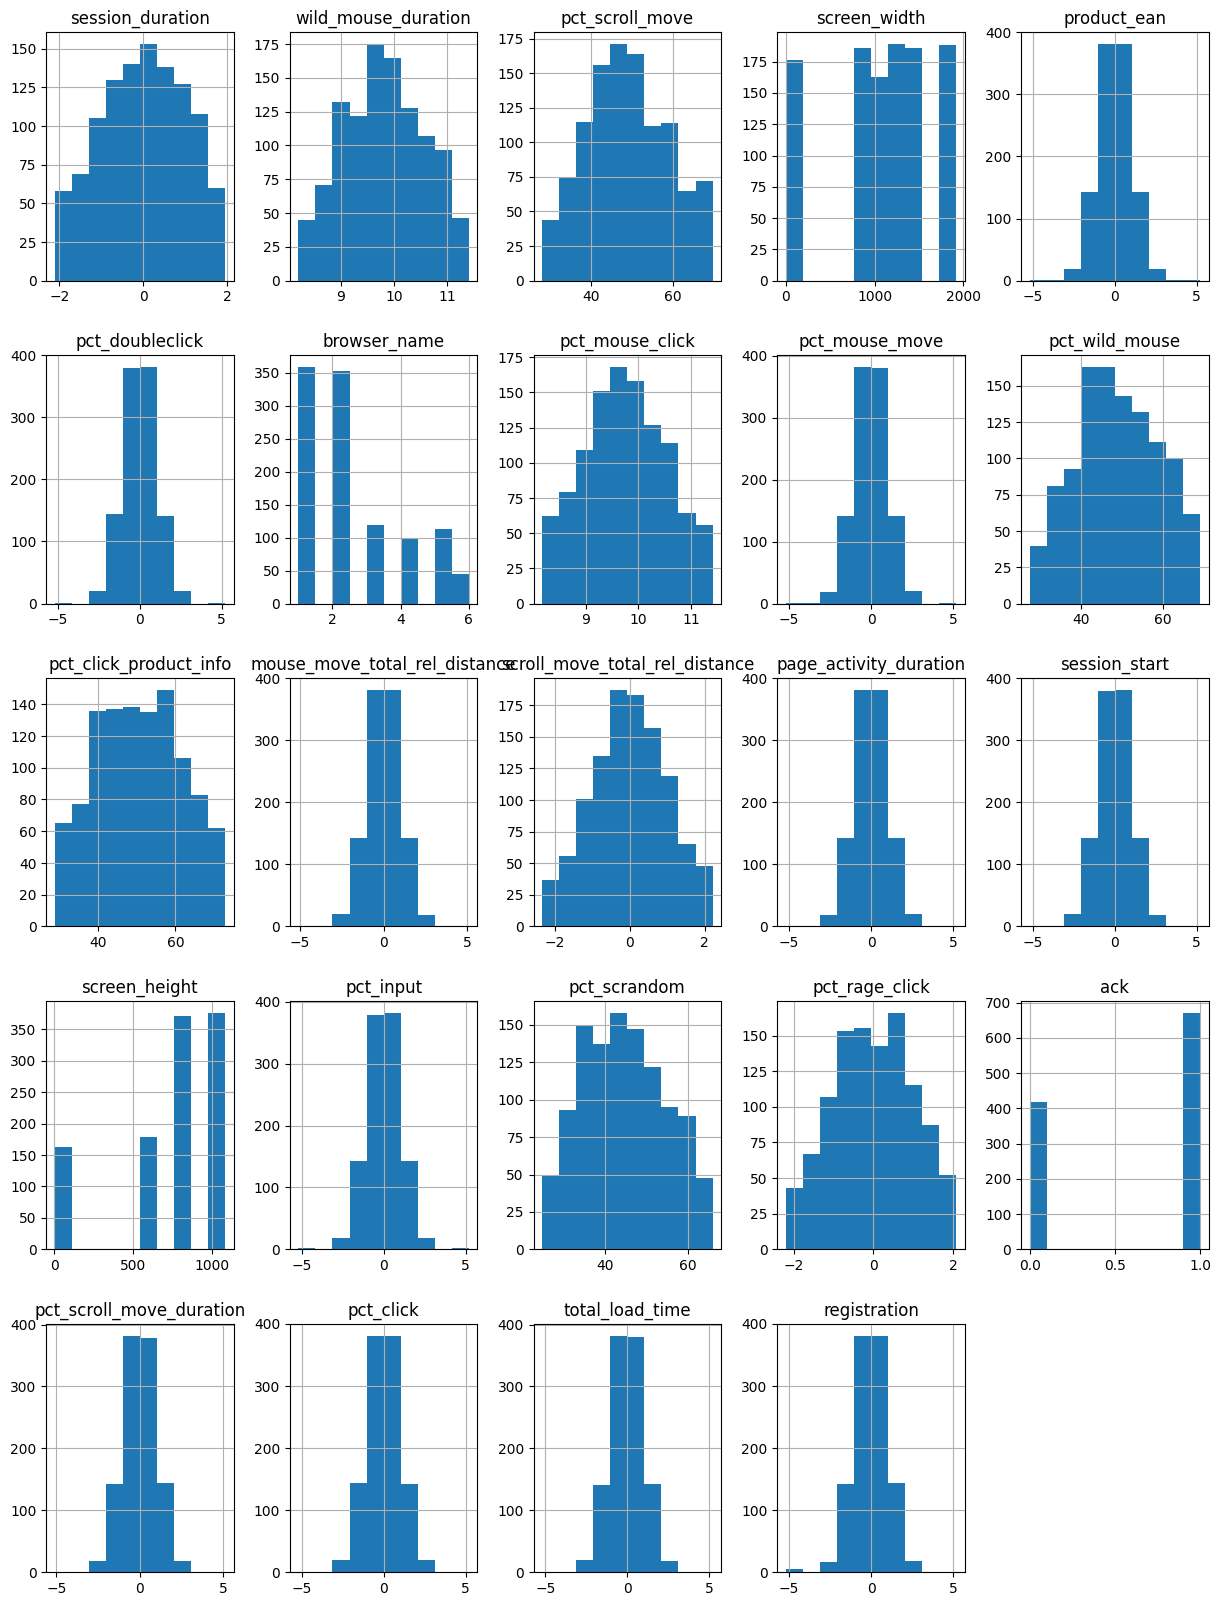

In [37]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
train_data.hist(ax = ax)

# Výber atribútov pre strojové učenie

Na výber atribútov sme použili dve metódy feature selection. Prvý spôsob je recursive feature elimination. Target atribut je ack.

In [38]:
X = train_data.drop("ack", axis=1) 
y = train_data["ack"] 

Pre túto metódu sme vytvorili subset, pretože spracovanie celkoveho datasetu trvalo pol hodiny, pretože je computationally expensive.

In [43]:
train_data_subset = train_data.sample(frac=0.1, random_state=42)

X_subset = train_data_subset.drop("ack", axis=1)
y_subset = train_data_subset["ack"]

estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X_subset, y_subset)
feature_names = X_subset.columns
print(feature_names[selector.support_])
print(pd.Series(selector.support_, index=train_data_subset.drop('ack', axis=1).columns))
print(selector.ranking_)

Index(['pct_mouse_move', 'mouse_move_total_rel_distance',
       'page_activity_duration', 'pct_scroll_move_duration', 'pct_click'],
      dtype='object')
session_duration                  False
wild_mouse_duration               False
pct_scroll_move                   False
screen_width                      False
product_ean                       False
pct_doubleclick                   False
browser_name                      False
pct_mouse_click                   False
pct_mouse_move                     True
pct_wild_mouse                    False
pct_click_product_info            False
mouse_move_total_rel_distance      True
scroll_move_total_rel_distance    False
page_activity_duration             True
session_start                     False
screen_height                     False
pct_input                         False
pct_scrandom                      False
pct_rage_click                    False
pct_scroll_move_duration           True
pct_click                          True
total

Druhý spôsob je použivanie select from model(logistic regression).

In [44]:
selector = SelectFromModel(estimator=LogisticRegression()).fit(X, y)

selected_features = X.columns[selector.get_support()]

print("Estimator Coefficients:", selector.estimator_.coef_)
print("Threshold:", selector.threshold_)
print("Selected Features:", selected_features)

X_new = selector.transform(X)
print(X_new.shape)

Estimator Coefficients: [[-1.42407977e-01  1.03131185e-01 -8.53315442e-03 -2.00875434e-04
  -1.08878915e-01  5.25609742e-01  9.77867285e-02  1.02481336e-01
  -1.05714355e-01  6.87757841e-03 -5.68697683e-03  1.93734171e+00
  -1.03518014e-01  3.46760001e-01  1.61931407e-01 -9.14949150e-07
  -1.24384845e-01 -1.82394254e-02 -3.24192510e-02  2.60796722e-01
  -1.23762382e-01 -7.26108791e-02 -1.07326450e-01]]
Threshold: 0.1954956880322063
Selected Features: Index(['pct_doubleclick', 'mouse_move_total_rel_distance',
       'page_activity_duration', 'pct_scroll_move_duration'],
      dtype='object')
(1088, 4)


C:\Users\patko\Desktop\iau\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RFE rekurzívne eliminuje najmenej dôležité vlastnosti. Hodnotí funkcie na základe dôležitosti, iteračne odstraňuje najmenej dôležité. Lineárna regresia má inú implementáciu. Koeficienty znamenajú dôležitosť vlastnosti. Ako vidíme, RFE vyžaduje viac času v porovnaní s lineárnou regresiou, preto sme vytvorili subset. Tiež si môžeme všimnúť, že niektoré atribúty sú výsledkom oboch metód.

In [45]:
cor = abs(train_data.corr()["ack"])
cor.sort_values(ascending=False)

ack                               1.000000
mouse_move_total_rel_distance     0.615775
pct_doubleclick                   0.245485
pct_click                         0.113310
scroll_move_total_rel_distance    0.098574
screen_width                      0.064102
pct_scroll_move_duration          0.054899
session_start                     0.053510
pct_input                         0.047897
session_duration                  0.046512
pct_click_product_info            0.045598
wild_mouse_duration               0.035084
total_load_time                   0.030078
pct_scrandom                      0.030031
pct_scroll_move                   0.027621
page_activity_duration            0.026372
product_ean                       0.025121
registration                      0.024315
pct_mouse_move                    0.015893
pct_wild_mouse                    0.013882
screen_height                     0.011278
browser_name                      0.011223
pct_rage_click                    0.009704
pct_mouse_c

Podľa korelačnej tabuľky vidíme, že väčšina atribútov má minimálnu koreláciu, avšak atribúty "mouse_move_total_rel_distance","pct_doubleclick" a "pct_click" sa zdajú byť najdôležitejšie

# Replikovateľnosť 

V tejto časti aplikujeme funkcie, ktoré sme používali pri realizácii predspracovania dát a vložíme ich do pipeliny.

In [50]:
def columns_name_to_index(arr_of_names, df):
 return [df.columns.get_loc(c) for c in arr_of_names if c in df]

In [46]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
quantil_transformer = make_column_transformer((QuantileTransformer(output_distribution="normal",
                                               random_state=0,
                                               n_quantiles=1000),
                                               columns_name_to_index(first_group_analysis,train_data)),
                                               remainder='passthrough')

In [52]:
power_transformer = make_column_transformer((PowerTransformer(method='yeo-johnson',standardize=True),columns_name_to_index(second_group_analysis,train_data)),remainder='passthrough')

In [53]:
minmax_scale = make_column_transformer((MinMaxScaler(),columns_name_to_index(third_group_analysis,train_data)),remainder='passthrough')

In [54]:
qt2 = make_column_transformer((QuantileTransformer(output_distribution="normal",
                                               random_state=0,
                                               n_quantiles=1000),
                                               columns_name_to_index(third_group_analysis,train_data)),
                                               remainder='passthrough')

In [55]:
std_scale = make_column_transformer((StandardScaler(),columns_name_to_index(second_group_analysis,train_data)),remainder='passthrough')

In [77]:
pipeline = Pipeline(steps=[('1', quantil_transformer),
                           ('2', power_transformer),
                           ('3', minmax_scale),
                           ('4', qt2),
                           ('5',std_scale),
                           ("6",FunctionTransformer(lambda x: pd.DataFrame(x, columns = train_data.columns)))], verbose=True)

pipeline.fit_transform(train_data)
train_data

[Pipeline] ................. (step 1 of 6) Processing 1, total=   0.0s
[Pipeline] ................. (step 2 of 6) Processing 2, total=   0.0s
[Pipeline] ................. (step 3 of 6) Processing 3, total=   0.0s
[Pipeline] ................. (step 4 of 6) Processing 4, total=   0.0s
[Pipeline] ................. (step 5 of 6) Processing 5, total=   0.0s
[Pipeline] ................. (step 6 of 6) Processing 6, total=   0.0s


,session_duration,wild_mouse_duration,pct_scroll_move,screen_width,product_ean,pct_doubleclick,browser_name,pct_mouse_click,pct_mouse_move,pct_wild_mouse,...,session_start,screen_height,pct_input,pct_scrandom,pct_rage_click,ack,pct_scroll_move_duration,pct_click,total_load_time,registration
6081,-1.938413,9.42120,62.18378,1280,1.245268,1.431000,4,10.01892,-1.259534,49.28919,...,-1.064865,1024,-0.590966,36.93296,-0.558106,0.0,-0.797709,-0.139755,1.291950,-0.161281
6480,1.457780,11.02687,58.09436,1366,0.144780,-0.193143,1,9.23904,0.286135,55.82571,...,-1.140077,1080,1.545927,32.37568,-0.721096,1.0,0.030894,-0.728240,0.091712,0.512061
10022,0.906768,9.52943,43.15284,800,-0.007900,-1.750760,5,9.44448,1.505318,64.95126,...,0.310149,600,-0.370221,40.15310,-1.427344,0.0,3.051447,2.283750,1.694503,5.199338
8703,0.703400,9.89068,36.71825,800,5.199338,1.225600,1,9.63908,-0.700626,62.75088,...,0.151988,1,0.135437,36.36618,1.309172,1.0,-0.035240,-0.216341,-1.140103,-0.633788
2410,1.063415,9.14510,33.66682,1280,-0.506348,-0.540882,5,10.28050,1.378114,40.35609,...,1.018778,600,-0.718462,30.72213,0.202349,1.0,0.122336,0.953493,2.033104,1.694556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10277,1.156507,10.50950,40.98174,1920,-1.255916,-1.359989,1,8.78935,-1.651969,50.80095,...,-0.325388,1080,0.785088,32.24363,0.896337,0.0,1.532163,0.851713,-1.674257,-0.224522
5561,0.920044,9.28069,45.32572,1366,-1.247505,-0.043924,4,11.34178,0.400635,50.57756,...,0.013801,1080,-0.710811,33.05358,-1.147965,1.0,-1.875395,-0.675316,-0.953143,-0.678433
4688,1.406693,9.02689,57.02549,1280,-0.651656,-0.622535,1,9.10892,-0.545256,47.06814,...,2.008324,1024,-1.052959,41.60605,-2.090529,1.0,-1.268222,-2.200956,0.245626,-0.038268
2929,-0.231103,9.88644,53.57626,1280,-0.820308,0.152031,1,9.71090,0.210702,41.76716,...,-0.711042,600,0.111962,42.03414,0.879337,0.0,-1.804087,-1.190336,-0.129438,-0.431225


In [79]:
train_data.to_csv('transformed_data.csv')

# Záver

V tejto časti projektu sme spojili dva datasety a upravili ich pre použitie v strojovom učení. Na začiatku sme nahradili niektoré textové informácie ich číselnými reprezentáciami a tiež sme ukázali, ako sa riiešia chýbajúce informácie v dátach. Extrémne hodnoty sme obmedzovali, aby sa nachádzali v štandardnom rozsahu. Na konci sme v rámci zadania na aplikovanie transformácií použili pipleine. Výsledkom tejto fázy je dataset pripravený na strojové učenie.